# **Airbnb location scoring prediction**

In this notebook, Airbnb data is used to predict whether a listing location would receive favourable location review scores from customers or not. This capability is important for anyone considering obtaining property with the intent of listing the said property on Airbnb, as the location affects the popularity and thus the success of such endeavour. Additionally, the opinion of customers may be very different from the experience of a local resident, and therefore it is not advisable to rely purely on local knowledge when starting a Airbnb business.

This notebook explores and demonstrates regression (XGBoost), classification (Random forest, XGBoost) and clustering (KMeans, Gaussian mixture) algorithms for solving this task.

The objectives are to:
 - Perform exploratory analysis on Airbnb data
 - Explore machine learning methods for predicting the "goodness" of a Airbnb listing location
 - Select the best performing models, and test their performance on all featured cities

Data obtained from: https://www.kaggle.com/datasets/alessiocrisafulli/airbnb-italy

## **Data loading and preparation**

In [43]:
# Set city for analysis
CITY = 'Roma'

# Whether the notebook should run models on all cities
RUN_SUMMARY = True

In [44]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from sklearn.cluster import KMeans, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (silhouette_score, accuracy_score, mean_squared_error, r2_score, confusion_matrix, recall_score, precision_score, 
                             ConfusionMatrixDisplay, roc_auc_score, classification_report, cohen_kappa_score, log_loss)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import xgboost as xgb

In [45]:
# Load data
df = pd.read_csv('Airbnb Italy/{}/listings.csv'.format(CITY))
pd.set_option('display.max_columns', None)

In [46]:
# Show info for identifying columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24782 entries, 0 to 24781
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            24782 non-null  int64  
 1   listing_url                                   24782 non-null  object 
 2   scrape_id                                     24782 non-null  int64  
 3   last_scraped                                  24782 non-null  object 
 4   source                                        24782 non-null  object 
 5   name                                          24779 non-null  object 
 6   description                                   24292 non-null  object 
 7   neighborhood_overview                         15433 non-null  object 
 8   picture_url                                   24782 non-null  object 
 9   host_id                                       24782 non-null 

First, only columns that are deemed reasonable for this analysis are selected for further exploration. This means that variables that are unique to a listing, such as listing description, id or host identifying data are dropped. 

*Note: it could be interesting to analyse the listing and neighbourhood descriptions to see whether they affect booking rates / customer ratings!*

In [47]:
# select only columns that are likely useful to the analysis
df = df[[
    'last_scraped',
    'neighbourhood_cleansed', 'latitude', 'longitude',
    'room_type', 'accommodates', 'bathrooms_text','bedrooms', 'amenities',
    'price',
    'number_of_reviews', 'first_review', 'last_review',
    'availability_30', 'availability_60', 'availability_90', 'availability_365',
    'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'reviews_per_month'
]]

### Null values
For null values, decision is made to drop all rows containing any null values as for no variable can a null value be accurately transformed into a valid value.

In [48]:
df.dropna(inplace=True)
df['last_scraped'].count() # n. of rows after dropping nulls

20340

**Fixing data types and values:**

In [49]:
# fix datetimes
df['last_scraped'] = df['last_scraped'].astype('datetime64[ns]')
df['first_review'] = df['first_review'].astype('datetime64[ns]')
df['last_review'] = df['last_review'].astype('datetime64[ns]')

## **Exploratory Analysis & Feature Engineering**
In this section, the variables chosen in the previous step are explored further, either one-by-one or as a group. This allows for estimating whether the variables might be correlated with the analysis object and/or each-other or not, which allows for the final feature selection to take place. Additionally, this should expose candidates for feature engineering by highlighting anomalies in the variable distributions.

### Review Scores
The dataset contains multiple features that describe the review scores of a listing.
 - **review_scores_rating:** overall score
 - **review_scores_accuracy:** listing accuracy score
 - **review_scores_cleanliness:** property cleanliness score
 - **review_scores_checkin:** check-in process score
 - **review_scores_communication:** host communication score
 - **review_scores_location:** location score
 - **review_scores_value:** value for money spent score

These features are explored to find if it is possible to detect fraudulent reviews and thus determine if certain listings should be dropped from the analysis.

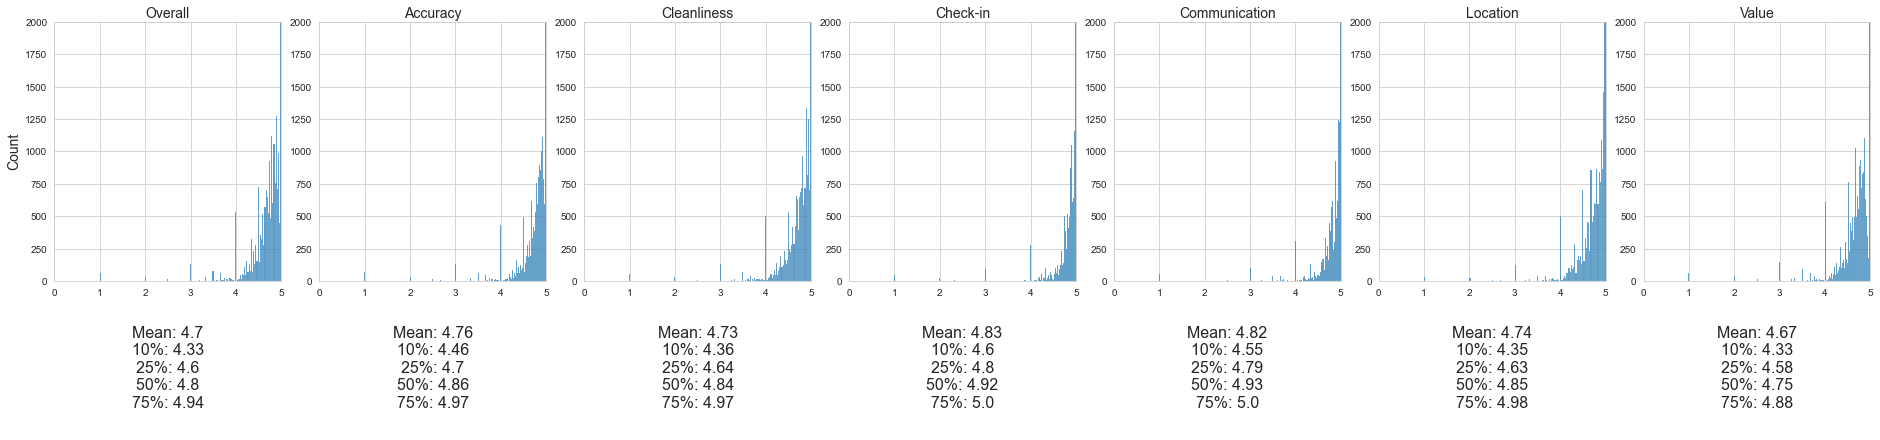

In [50]:
cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
colnames = ['Overall', 'Accuracy', 'Cleanliness', 'Check-in', 'Communication', 'Location', 'Value']

fig = plt.figure(constrained_layout=True, figsize=(26, 6))
heights = [2,1]
gs = fig.add_gridspec(ncols=7, nrows=2, height_ratios=heights)

for col in range(7):
    ax = fig.add_subplot(gs[0, col])
    sns.histplot(data=df, x=cols[col], ax=ax)
    ax.set_xlabel(colnames[col], size=14)
    ax.set_ylim(0, 2000)
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_xlim(0, 5)
    ax.set_ylabel('')
    ax.xaxis.set_label_position('top')
    
anno_opts = dict(xy=(0.5, 0.5), xycoords='axes fraction', va='center', ha='center', size=16)
    
for col in range(7):
    ax = fig.add_subplot(gs[1, col])
    ax.axis('off')
    s = 'Mean: {}\n10%: {}\n25%: {}\n50%: {}\n75%: {}'.format(df[cols[col]].mean().round(2), df[cols[col]].quantile(0.1), df[cols[col]].quantile(0.25), df[cols[col]].quantile(0.5), df[cols[col]].quantile(0.75))
    ax.annotate(s, **anno_opts)
    
fig.axes[0].set_ylabel('Count', size=14)

plt.show()

It is clear that Airbnb users don't utilize the full 0-5 scale when reviewing rentals, as all review features have mean (and median) scores of close to five. Additionally, from the graphs it is obvious that perfect scores of 5 are by far the most frequently occurring score. This makes it very hard to accurately differentiate between the listings.

#### Total score<br>
Let's calculate total review score as the sum of the review variables and then display its distribution.

In [51]:
df['review_scores_total'] = (df['review_scores_rating'] + df['review_scores_accuracy'] + df['review_scores_cleanliness'] + 
                             df['review_scores_checkin'] + df['review_scores_communication'] + df['review_scores_value'] + df['review_scores_location'])

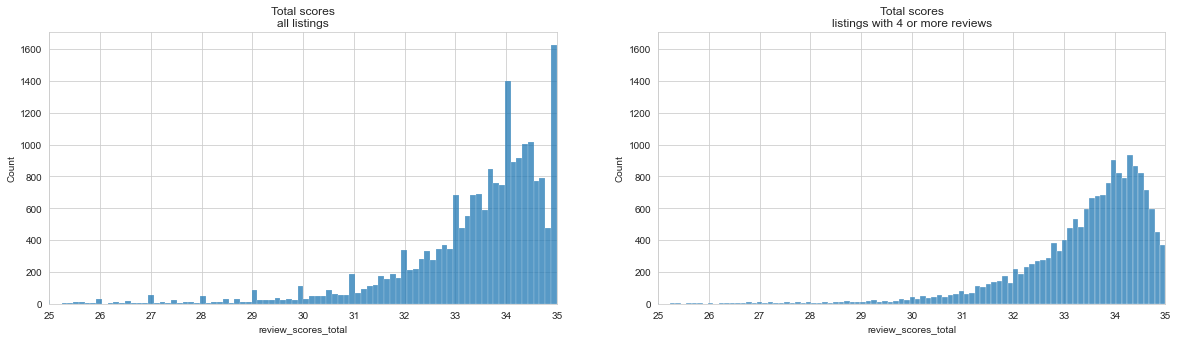

25%: 32.92
50%: 33.75
75%: 34.30


In [52]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

sns.histplot(data=df, x='review_scores_total', ax=ax[0])
ax[0].set_xlim(25, df['review_scores_total'].max())
ax[0].set_xticks(range(25, int(df['review_scores_total'].max())+1, 1))
ax[0].set_title('Total scores\nall listings')

sns.histplot(data=df.query('number_of_reviews >= 4'), x='review_scores_total', ax=ax[1])
ax[1].set_xlim(25,df['review_scores_total'].max())
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xticks(range(25, int(df['review_scores_total'].max())+1, 1))
ax[1].set_title('Total scores\nlistings with 4 or more reviews')

plt.show()

print('25%: {:.2f}'.format(df.query('number_of_reviews >= 4')['review_scores_total'].quantile(0.25)))
print('50%: {:.2f}'.format(df.query('number_of_reviews >= 4')['review_scores_total'].quantile(0.50)))
print('75%: {:.2f}'.format(df.query('number_of_reviews >= 4')['review_scores_total'].quantile(0.75)))

The distribution shows that an abnormally large number of listings has the perfect combined score of 35. Without this anomaly, the distribution seems a lot more realistic (on the right).

This concentration of perfect reviews could be explained by listing with only one (to few) reviews. Logically, this could be caused by, for example, property owners asking their acquaintances to review a listing favorably.

*It should be noted, that limiting by the number of reviews also removes many low scores (total of under 30) which would imply that there are also  many listings that receive a single legitimate visitor who gives a relatively bad rating and from then on other visitors avoid the property.*

**Proposal:** Listings with under **four** reviews are dropped from the analysis.

In [53]:
df = df.query('number_of_reviews >= 4')
df['number_of_reviews'].count()

16896

In [54]:
# Review related var correlation matrix
corr = df[['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location', 'review_scores_value', 'review_scores_total']].corr()
corr.style.background_gradient(cmap='Blues', axis=None).format(precision=2)

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,review_scores_total
review_scores_rating,1.00,0.84,0.77,0.71,0.73,0.36,0.86,0.93
review_scores_accuracy,0.84,1.00,0.71,0.70,0.71,0.33,0.81,0.89
review_scores_cleanliness,0.77,0.71,1.00,0.56,0.55,0.26,0.72,0.81
review_scores_checkin,0.71,0.70,0.56,1.00,0.77,0.29,0.66,0.81
review_scores_communication,0.73,0.71,0.55,0.77,1.00,0.30,0.68,0.82
review_scores_location,0.36,0.33,0.26,0.29,0.30,1.00,0.38,0.52
review_scores_value,0.86,0.81,0.72,0.66,0.68,0.38,1.00,0.90
review_scores_total,0.93,0.89,0.81,0.81,0.82,0.52,0.90,1.00


**Key points from the correlation matrix:**
 - Different score types are from noticeably correlated with each other, especially with the total score
 - Exception is location, as it has a correlation of < 0.4 with other variables. This indicates that the location does not affect the overall rating, likely due to customers knowing that the location is given and not in the hands of the host.
 - The general rating of a listing seems to be most affected by listing accuracy, perceived value and cleanliness.

**This supports the hypothesis that location score could be beneficial to analyze separately!**

#### Categorization:

As the Airbnb review scores are distributed very unevenly, the review scores are transformed into categories and awarded points based on the categorization. The logic is that the reviews are split to four quantiles, with the bottom 25% receiving zero points and the top 25% in turn received the full three points.

In [55]:
# variable-by-variable
vars = ['rating', 'accuracy', 'cleanliness', 'checkin', 'communication', 'value', 'location']

df['points_total'] = 0

for v in vars:
    q25 = df['review_scores_' + v].quantile(0.25)
    q50 = df['review_scores_' + v].quantile(0.50)
    q75 = df['review_scores_' + v].quantile(0.75)
    
    criteria = [df['review_scores_' + v] <= q25, (df['review_scores_' + v] > q25) & (df['review_scores_' + v] <= q50), (df['review_scores_' + v] > q50) & (df['review_scores_' + v] <= q75), df['review_scores_' + v] > q75]
    values = [0, 1, 2, 3]
    df['points_' + v] = np.select(criteria, values, 0)
    df['points_total'] += df['points_' + v]


### Popularity

**Objective:** Find out if it is possible to estimate the popularity of a listing.

It might be interesting to determine how much a good location affects the popularity of a listing. For this, a way of measuring popularity is needed.

As the dataset is missing data on reservations per month, popularity has to be estimated using availability and review metrics.<br>
Possible variables to use for calculating popularity are:

For past popularity
 - **number_of_reviews**
 - **first_review** and **last_review**, for incorporating time data
 - **number_of_reviews_ltm** and **number_of_reviews_l30d**, for (near) past activity data
 - **reviews_per_month**, for old listings this is likely significantly affected by the covid-19 pandemic!

For future popularity
 - **availability_30**, **availability_60**, **availability_90**, **availability_365** for near future availability data

Ideally, the popularity metric should explain both past and future popularity, unless it can be proven that past performance perfectly predicts the future.

In [56]:
# calculate diff between scrape date and first review, roughly tells the listing age in days
df['days_active'] = (df['last_scraped'] - df['first_review']).dt.days

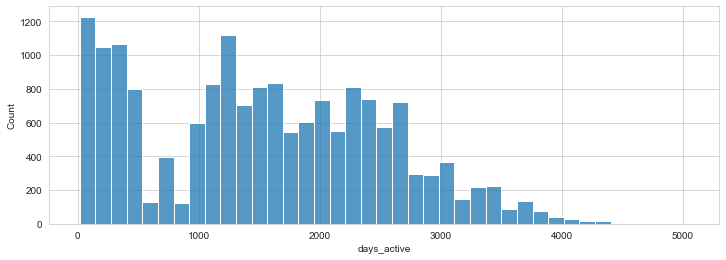

All listings:
                   days_active  reviews_per_month
days_active           1.000000          -0.286026
reviews_per_month    -0.286026           1.000000

Very recent listings:
                   days_active  reviews_per_month
days_active           1.000000          -0.202433
reviews_per_month    -0.202433           1.000000


In [57]:
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(data=df, x='days_active', ax=ax)
plt.show()
print('All listings:')
print(df[['days_active', 'reviews_per_month']].corr())
print('\nVery recent listings:')
print(df.query('days_active < 200')[['days_active', 'reviews_per_month']].corr())

I suspect that the difference between the old and new listings on correlation of *days_active* and *reviews_per_month* is indeed due to the covid pandemic.<br/>**Proposed resolution is to remove "the pandemic time" from those listings that have been created before or during the pandemic.**

In practice,
 - Start of the pandemic is defined as 2020-03-01
 - End of the pandemic is defined as 2021-12-31, as travel had started opening up in europe during this time thanks to vaccinations
 - Calculate *pandemic_days* as...
    - min( max(*2022-05-31* - *first_review*, 0) *2021-12-31* - *2020-03-01* )
 - Calculate *days_active_alt* as *days_active* - *pandemic_days*
 - Calculate *reviews_per_month_alt* as *number_of_reviews* / (*days_active_alt*/(365/12))
 - **Note:** Reviews submitted during the covid pandemic are **not** omitted in order to simplify the analysis! This could be done by obtaining review data from the same data source!
    - While there are some reviews from that timeframe, the number per listing, and therefore the supposed effect, is very low.

In [58]:
pandemic_start = pd.to_datetime('2020/03/01')
pandemic_end = pd.to_datetime('2021/12/31')

df['pandemic_days'] = np.minimum(np.maximum((pandemic_end - df['first_review']).dt.days, 0), (pandemic_end - pandemic_start).days)
df['days_active_alt'] = df['days_active'] - df['pandemic_days']
df['reviews_per_month'] = df['number_of_reviews'] / (df['days_active_alt'] / (365 / 12))

print(df.query('pandemic_days == 0')['reviews_per_month'].mean())
print(df.query('pandemic_days > 0')['reviews_per_month'].mean())

df.drop(['pandemic_days', 'days_active_alt'], axis=1, inplace=True)

3.303695849614061
2.447352190753341


Ideally, the mean values for pre- and after-pandemic listings would be very similar.

The result is not perfect, but workable. There is also a possibility that either Airbnb has surged in popularity after the pandemic, or new listings receive increased traffic during their (approx.) first year. There is not, however, sufficient data for reliably determining this and thus this possible effect is ignored.

In [59]:
corr = df[['reviews_per_month', 'number_of_reviews_l30d', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'points_rating', 'points_location', 'points_total']].corr()
corr.style.background_gradient(cmap='Blues', axis=None).format(precision=2)

,reviews_per_month,number_of_reviews_l30d,availability_30,availability_60,availability_90,availability_365,points_rating,points_location,points_total
reviews_per_month,1.00,0.68,-0.07,-0.01,0.06,0.06,0.09,0.15,0.08
number_of_reviews_l30d,0.68,1.00,-0.06,0.00,0.10,0.14,0.10,0.14,0.09
availability_30,-0.07,-0.06,1.00,0.85,0.70,0.29,-0.10,-0.10,-0.13
availability_60,-0.01,0.00,0.85,1.00,0.92,0.42,-0.10,-0.09,-0.14
availability_90,0.06,0.10,0.70,0.92,1.00,0.54,-0.07,-0.03,-0.10
availability_365,0.06,0.14,0.29,0.42,0.54,1.00,-0.04,0.01,-0.06
points_rating,0.09,0.10,-0.10,-0.10,-0.07,-0.04,1.00,0.28,0.89
points_location,0.15,0.14,-0.10,-0.09,-0.03,0.01,0.28,1.00,0.45
points_total,0.08,0.09,-0.13,-0.14,-0.10,-0.06,0.89,0.45,1.00


**reviews_per_month** and **number_of_reviews_l30d**:
 - Well performing listings, in this case outliers, are quite easy to identify as most listings seem to receive between zero and five reviews per month
 - Past popularity seems to somewhat indicate current popularity, based on the correlation between the variables (~0.6)
 - number_of_reviews_l30d is affected by the scrape date, which does not take seasonality into account

**future availability**:
 - Both review variables have some correlation with the availability variables, most with the availability during the next 30 days.
    - At 90 days the correlation is practically zero
 - All availability variables exhibit a clear "spike" which can be inferred as the usual availability ratio in the given timeframe.
    - On average, shorter the timeframe, smaller the availability ratio
 - Availabilities of 30, 60 and 90 days are clearly correlated with each other, meaning that listings that are "popular" 30 days out, are also popular when the timeframe is increased.
    - 365 less so, how to approach?
 - Availability is consistently negatively correlated with the review score variables, which would indicate that at least some are worthwhile to include in the analysis.

As with review scores, the listings will be scored (with integer points) from 0 to 3 on both past popularity and future popularity. This should give us a reasonable representation of long term listing popularity.

**reviews per month**: 
<br>points by quartile, lowest 25% get 0 etc.

**availability**: average of availability_30, availability_60 and availability_90
<br>lower is better, 0 being best, 1 being worst
<br>**points:** 3-0, by quartile

<br>**Popularity**:
<br>Thus, the proposed representation for popularity is the sum of points from reviews per month (past popularity) and availability (near future popularity)

In [60]:
df['availability'] = (df['availability_30'] / 3) + (df['availability_60'] / 3) + (df['availability_90'] / 3)

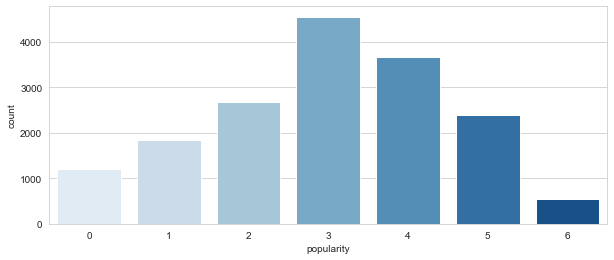

In [61]:
r_25 = df['reviews_per_month'].quantile(0.25)
r_50 = df['reviews_per_month'].quantile(0.5)
r_75 = df['reviews_per_month'].quantile(0.75)

criteria = [df['reviews_per_month'] <= r_25, (df['reviews_per_month'] > r_25) & (df['reviews_per_month'] <= r_50), (df['reviews_per_month'] > r_50) & (df['reviews_per_month'] <= r_75), df['reviews_per_month'] > r_75]
values = [0, 1, 2, 3]
df['reviews_per_month_categ'] = np.select(criteria, values, 0)

a_25 = df['availability'].quantile(0.25)
a_50 = df['availability'].quantile(0.5)
a_75 = df['availability'].quantile(0.75)

criteria = [df['availability'] <= a_25, (df['availability'] > a_25) & (df['availability'] <= a_50), (df['availability'] > a_50) & (df['availability'] <= a_75), df['availability'] > a_75]
values = [3, 2, 1, 0]
df['availability_categ'] = np.select(criteria, values, 0)

df['popularity'] = df['reviews_per_month_categ'] + df['availability_categ']

fig, ax = plt.subplots(figsize=(10,4))
sns.countplot(data=df, x='popularity', palette='Blues', ax=ax)
plt.show()

### Property

**Accommodates:**

Distribution of samples; small listings seem to be a lot more common than large to very large properties.

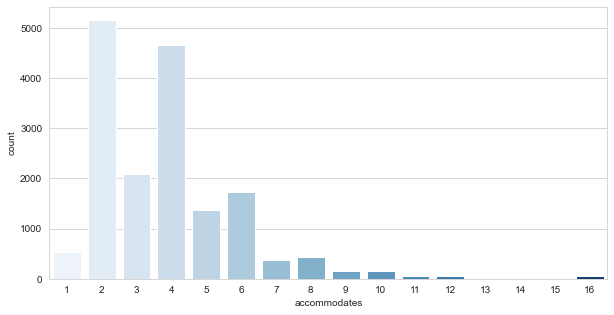

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=df, x='accommodates', ax=ax, palette='Blues')
plt.show()

**Amenities:**
<br>It could be interesting to explore whether listings in a "good" location have worse amenities than listings in bad locations in a similar price bracket - e.g. do you have to give up amenities if you want to stay in a stellar location?

However, for the purposes of this analysis this factor is ignored.

In [63]:
df.drop(['amenities'], axis=1, inplace=True)

**Price:**
<br>Price denotes the daily price. It is currently represented as a string, but we'll change it to a integer by removing the dollar signs and rounding if applicable.

In [64]:
df['price'] = pd.to_numeric(df['price'].str.replace('$','', regex=True).str.replace(',','', regex=True)).astype(int)

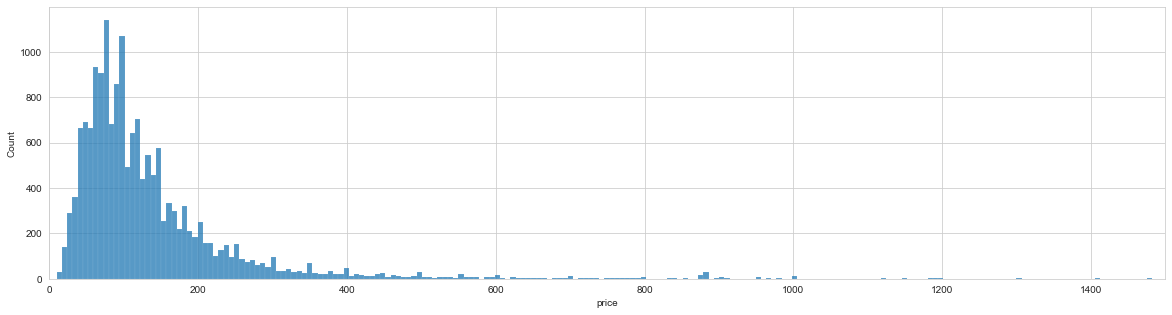

In [65]:
fig, ax = plt.subplots(figsize=(20,5))
sns.histplot(data=df, x='price', ax=ax)
ax.set_xlim(0, 1500)
plt.show()

There is slight correlation between the target variable(s) and host being a superhost and the number of people the property accommodates. Thus these features are candidates for being used in the predictive models.

## **Train-test-val Split & Feature Selection**

At this point, the data is split into training, validation and testing sets with a ratio of **60/20/20** respectively. The training set is used to train predictive models, which are then compared using the validation set. The test set is only used to report the final performance on unseen data of a chosen implementation.

In [66]:
df.head(1)

,last_scraped,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,price,number_of_reviews,first_review,last_review,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,review_scores_total,points_total,points_rating,points_accuracy,points_cleanliness,points_checkin,points_communication,points_value,points_location,days_active,availability,reviews_per_month_categ,availability_categ,popularity
0,2022-09-12,VII San Giovanni/Cinecittà,41.78984,12.60899,Private room,2,1 shared bath,1.0,45,213,2017-04-09,2022-07-12,8,38,68,343,8,0,4.74,4.84,4.92,4.85,4.85,4.65,4.8,4.938072,33.65,9,1,1,2,1,1,2,1,1982,38.0,3,0,3


In [67]:
targets = ['review_scores_location', 'points_location',
           'availability', 'availability_categ', 'reviews_per_month', 'reviews_per_month_categ', 'popularity'
           ]

y = df[targets]
X = df[['longitude', 'latitude', 'neighbourhood_cleansed']]

# split to train, test, val - 60%, 20%, 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

## **Predicting Location Score**

The exact location of a listing is known, expressed by latitude and longitude as well as the city specific neighbourhood. The goal is to estimate the **location review score** for a given listing based on the location and the review scores of nearby listings - making this a **regression problem**.

It is likely, that the most accurate result could be obtained by finding the nearest neighbour(s) for each sample and predicting the score based on those. This approach is, however, overly expensive computationally when the number of samples is high.

Ways of approaching this task:
 - **Naive baseline:**
    - *Predicted score is the mean of all training samples*
    - *Very inaccurate, does not take location into account*
 - **Known neighbourhood division:**
    - *Still quite naive, but likely an improvement over the baseline*
    - *Based on assumption that the original data for the neighbourhood is accurate, might not hold for all cities?*
    - *Does not take differences inside a neighbourhood/district/region, such as public transit or distance to closest services, into account*
 - **Clustering methods:**
    - *Assumes that there are differences between areas inside the same neighbourhood/district*
    - *Few clustering methods can be used to predict new data as is needed here - **the model selection is limited to methods that use centroids!***
 - **Other ML methods:**
    - *Which methods should be explored?*

Alternatively, **location quartiles** can be used as the target, which turns this task into a **classification problem**, allowing for different approaches.

### **Location Review Score**

#### Naive model: Mean value

First, the performance of a naive predictive model is tested. Here, the location score is predicted to simply be the mean of the training set. This establishes a baseline performance that further on allows for determining if the more advanced model outperform the baseline.

In [68]:
y_val['naive_mean'] = y_train['review_scores_location'].mean()
mse_naive = mean_squared_error(y_val['review_scores_location'], y_val['naive_mean'])
r2_naive = r2_score(y_val['review_scores_location'], y_val['naive_mean'])

print('Naive baseline')
print('On validation set')
print('    MSE: {:.3f}'.format(mse_naive))
print('    R2: {:.4f}'.format(r2_naive))
y_val.drop(['naive_mean'], axis=1, inplace=True)

Naive baseline
On validation set
    MSE: 0.062
    R2: -0.0006


#### Naive model: Neighbourhood Means

Using the neighbourhoods present in the data as ready-made clusters. This means that a new listing located in given neighbourhood, would be predicted to obtain location review score based on the neighbourhood mean (or other measure).

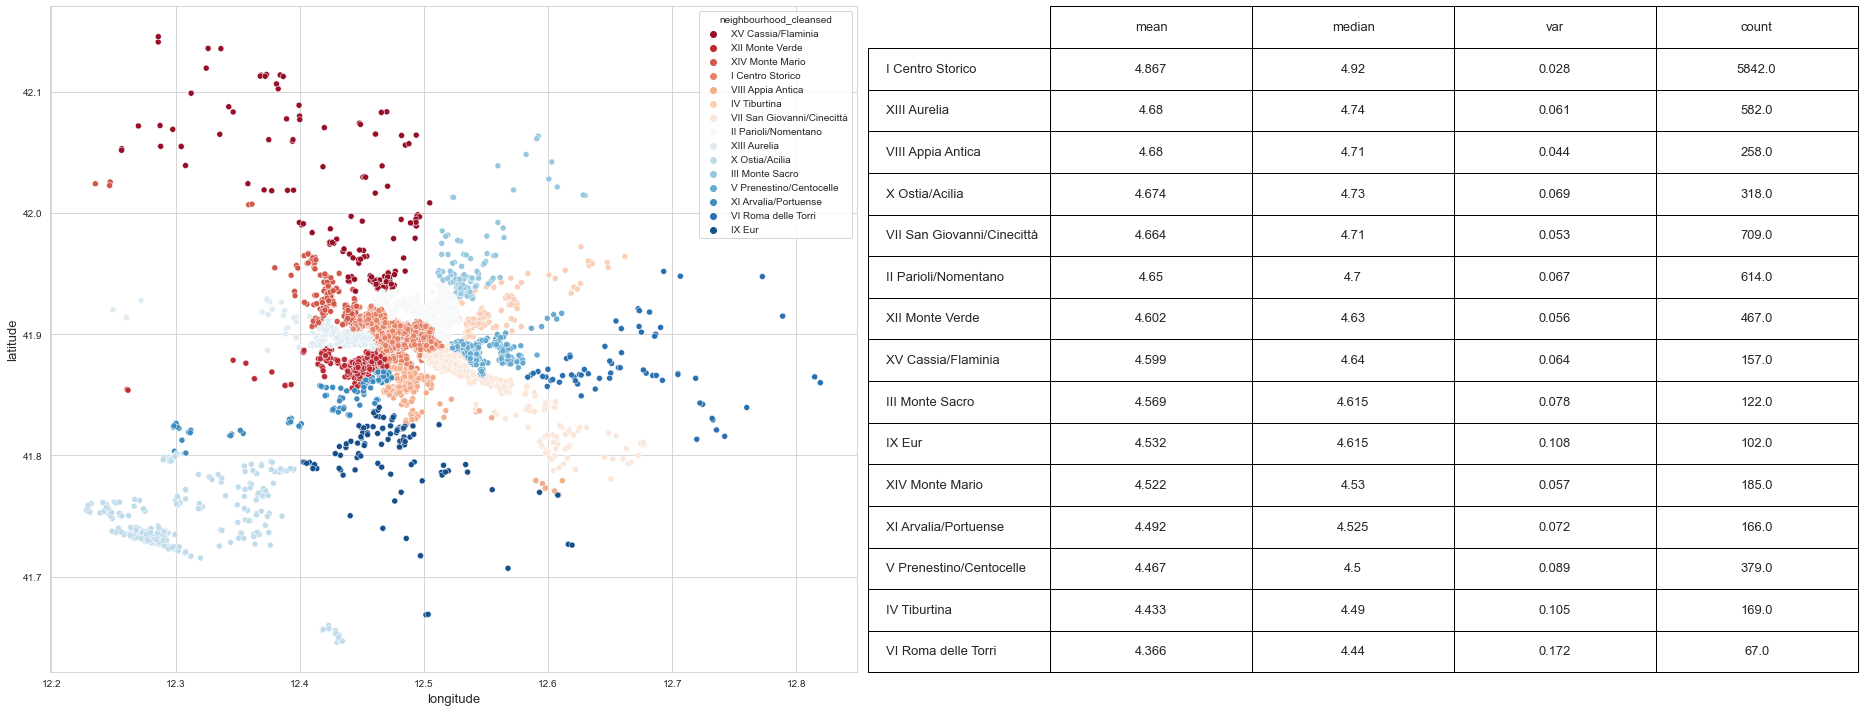

In [69]:
# plot neighbourhoods scatter
fig, ax = plt.subplots(1, 2, figsize=(26, 10))
sns.scatterplot(data=X_train, x='longitude', y='latitude', hue='neighbourhood_cleansed', palette='RdBu', ax=ax[0])
ax[0].set_ylabel('latitude', size=13)
ax[0].set_xlabel('longitude', size=13)

# plot neighbourhoods table
X_train['review_scores_location'] = y_train['review_scores_location']
ndf = X_train.groupby('neighbourhood_cleansed')['review_scores_location'].agg(['mean', 'median', 'var', 'count']).sort_values(by='mean', ascending=False).round(3)
X_train.drop(['review_scores_location'], axis=1, inplace=True)

ax[1].axis('off')
font_size = 13
bbox = [0, 0, 1, 1]
tbl = ax[1].table(cellText=ndf.values, rowLabels=ndf.index, bbox=bbox, colLabels=ndf.columns, cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(font_size)

plt.tight_layout()
plt.show()

In [70]:
# aggregated neighbourhood data is stored in ndf from previous step
y_pred_n_mean = X_val['neighbourhood_cleansed'].map(dict(ndf.reset_index()[['neighbourhood_cleansed', 'mean']].values))

In [71]:
mse_n = mean_squared_error(y_val['review_scores_location'], y_pred_n_mean)
r2_n = r2_score(y_val['review_scores_location'], y_pred_n_mean)

print('Neighbourhood Mean')
print('On validation set')
print('    MSE: {:.3f}'.format(mse_n))
print('    R2: {:.2f}'.format(r2_n))

Neighbourhood Mean
On validation set
    MSE: 0.042
    R2: 0.32


We can see, that at least in Rome, the neighbourhoods cover rather large areas, and have a very imbalanced distribution. While there is a clear difference between the best and worst neighbourhoods, it is very unlikely that this division represents the location ratings that accurately (at least in the case of the majority class).

#### ML: Clustering - KMeans

1. Determine the number of clusters using the **Elbow Method** and comparing **Silhouette Scores**
    - Assumption is that the optimal K should be higher than the number of neighbourhoods * 2, as the goal is to differentiate areas inside a neighbourhood. 
    - \* 2 is added to forbid choosing values too close to the n of neighbouthood
2. Cluster the data using **KMeans** clustering with the optimal K
3. Predict location score as the mean of a cluster

In [72]:
#elbow & silhouette, test different K values
sum_of_squared_distances = []
silhouette_avg = []

K = range(len(df['neighbourhood_cleansed'].unique()) * 2,101)
for num_clusters in K:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_train[['longitude', 'latitude']])
    cluster_labels = kmeans.labels_
    
    sum_of_squared_distances.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(X_train[['longitude', 'latitude']], cluster_labels))
    
# choose the highest K where K > number of neighbourhoods in the data
sil = pd.DataFrame.from_dict(dict(zip(K, silhouette_avg)), orient='index', columns=['score'])
#sil = sil[sil.index > len(df['neighbourhood_cleansed'].unique()) * 2]
K_value = sil.idxmax(axis=0).values[0]
optimal_sil_score = sil['score'].max()
print(K_value)
print('{:.3f}'.format(optimal_sil_score))

90
0.422


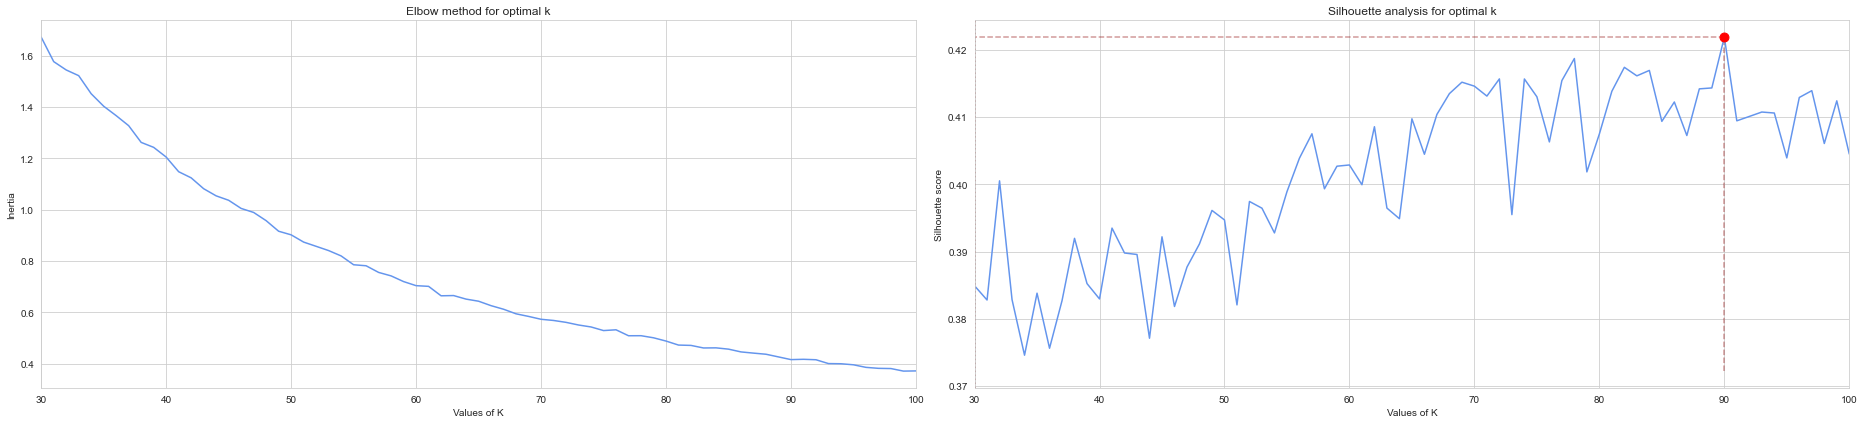

In [73]:
# plot elbow and silhouette
fig, ax = plt.subplots(1,2, figsize=(26,6))

ax[0].plot(K, sum_of_squared_distances,'-', color='cornflowerblue')
ax[0].set_xlabel('Values of K')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Elbow method for optimal k')
ax[0].set_xlim(len(df['neighbourhood_cleansed'].unique()) * 2,100)

ax[1].plot(K, silhouette_avg,'-', color='cornflowerblue')
ax[1].set_xlabel('Values of K')
ax[1].set_ylabel('Silhouette score')
ax[1].set_title('Silhouette analysis for optimal k')
ax[1].set_xlim(len(df['neighbourhood_cleansed'].unique()) * 2,100)

# plot optimal K
ax[1].scatter(K_value, optimal_sil_score, c='red', s=80, zorder=2)
ax[1].vlines(x=K_value, ymin=ax[1].get_ylim()[0], ymax=optimal_sil_score, color='darkred', alpha=0.4, zorder=1, linestyles='dashed')
ax[1].hlines(y=optimal_sil_score, xmin=10, xmax=K_value, color='darkred', alpha=0.4, zorder=1, linestyles='dashed')

# plot number of neighbourhoods * 2
ax[1].axvline(x=len(df['neighbourhood_cleansed'].unique()) * 2, c='darkred', linestyle=':', zorder=2)

plt.tight_layout()
plt.show()

It is difficult to detect a noticeable elbow from the first plot. Thus, the optimal K-value is chosen by silhouette scores by omitting K-values less or equal to number of neighbourhoods and choosing the K-value with the highest silhouette score. This should give enough granularity to detect differences inside a neighbourhood and thus better predict the location scores. 

The silhouette score of around 0.425 indicates that the clusters are somewhat, but not perfectly, distingushed from each other.

In [74]:
# fit KMeans clustering on training set
kmeans = KMeans(n_clusters=K_value)
kmeans.fit(X_train[['longitude', 'latitude']])

# predict clusters for train and validation
y_train_cluster = kmeans.predict(X_train[['longitude', 'latitude']])
y_val_cluster = kmeans.predict(X_val[['longitude', 'latitude']])

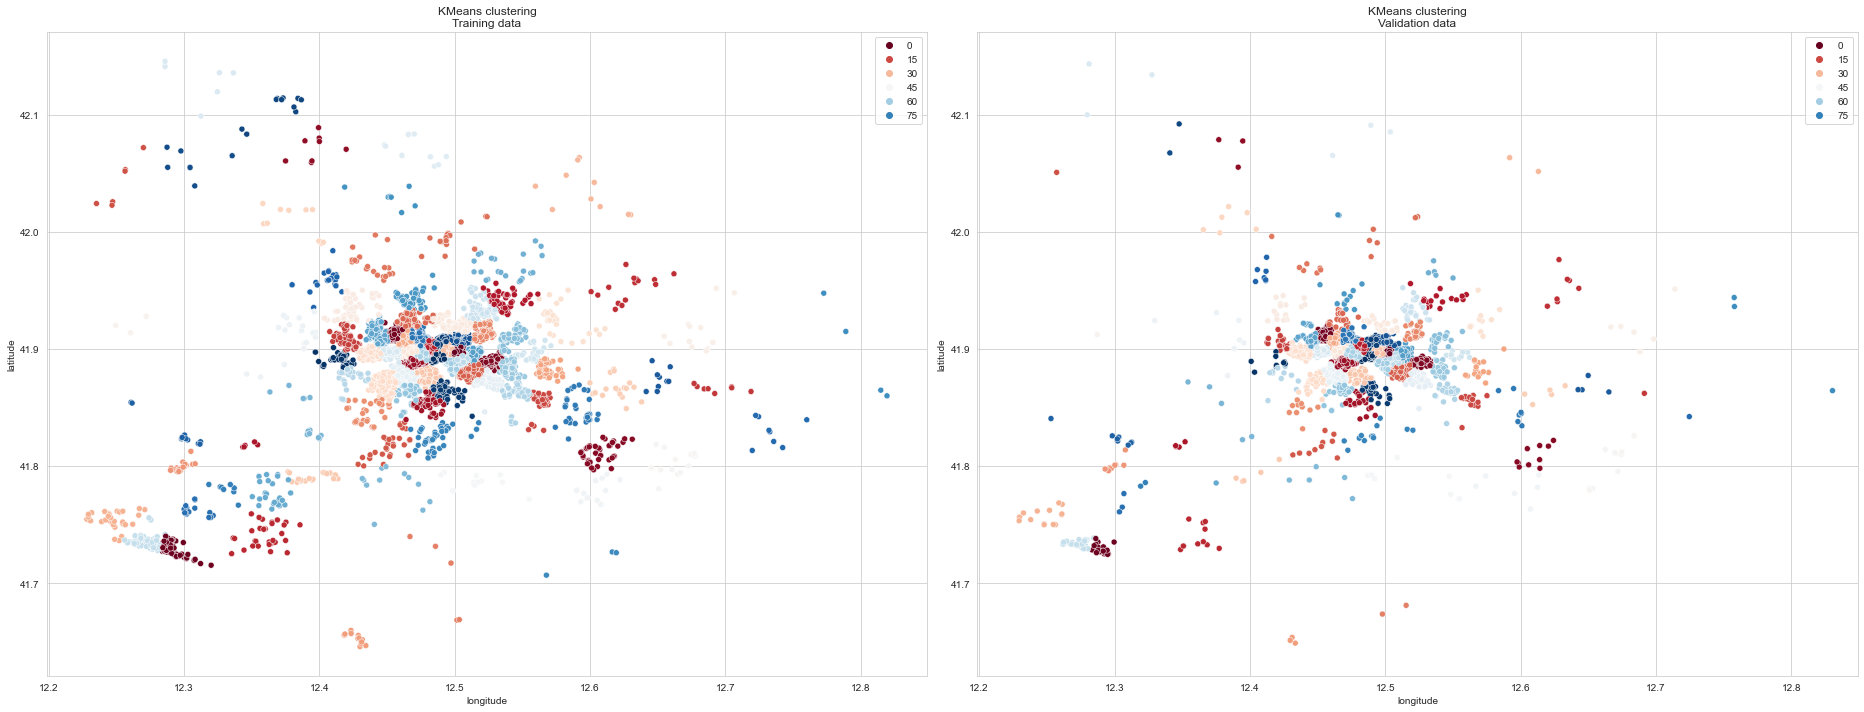

In [75]:
# plot clustering for train and validation
fig, ax = plt.subplots(1,2, figsize=(26, 10))

sns.scatterplot(data=X_train, x='longitude', y='latitude', palette='RdBu', hue=y_train_cluster, ax=ax[0])
ax[0].set_title('KMeans clustering\nTraining data')

sns.scatterplot(data=X_val, x='longitude', y='latitude', palette='RdBu', hue=y_val_cluster, ax=ax[1])
ax[1].set_title('KMeans clustering\nValidation data')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())

plt.tight_layout()
plt.show()

It is clear that the result of the clustering algorithm is very different from the original neighbourhoods, with individual clusters encompassing significantly smaller areas. Next, calculate MSE and R2 for this method:

In [76]:
# calculate cluster means TRAINING SET
y_train['cluster'] = y_train_cluster
temp = y_train.groupby('cluster')['review_scores_location'].agg(['mean'])

y_val['cluster'] = y_val_cluster

y_pred_km = y_val['cluster'].map(dict(temp.reset_index()[['cluster', 'mean']].values))

mse_km = mean_squared_error(y_val['review_scores_location'], y_pred_km)
r2_km = r2_score(y_val['review_scores_location'], y_pred_km)

print('KMeans Clustering')
print('On validation set')
print('    MSE: {:.3f}'.format(mse_km))
print('    R2: {:.2f}'.format(r2_km))

KMeans Clustering
On validation set
    MSE: 0.035
    R2: 0.43


#### ML: Clustering - Gaussian Mixture

Create a gaussian mixture model for classification, using optimal K value from the previous step as the number of components. Final predicted location score is calculated by multiplying the probabilities for an sample to belong to each cluster with the corresponding cluster mean scores and summing the results. This way, a sample that is predicted to belong into multiple clusters (with varying probabilities), gets weighted values of these possible clusters as the predicted value.

In [77]:
X_gm = X_train[['longitude', 'latitude']]

gm = GaussianMixture(n_components=K_value, covariance_type='full')
gm.fit(X_gm)

y_train_gm = gm.predict(X_gm)
y_val_gm_proba = gm.predict_proba(X_val[['longitude', 'latitude']])

In [78]:
# cluster means as list from training set, index denotes cluster number and the value denotes the mean location score of that cluster
y_train['cluster'] = y_train_gm
temp = y_train.groupby('cluster')['review_scores_location'].agg(['mean'])
gm_cluster_means = list(dict(temp.reset_index()[['cluster', 'mean']].values).values())

# calculate predicted location score by: likelihood of belonging into each cluster * cluster mean scores
y_pred_gm = []
for row in y_val_gm_proba:
    y_pred_gm.append((row * gm_cluster_means).sum())

mse_gm = mean_squared_error(y_val['review_scores_location'], y_pred_gm)
r2_gm = r2_score(y_val['review_scores_location'], y_pred_gm)

print('Gaussian Mixture Clustering')
print('On validation set')
print('    MSE: {:.3f}'.format(mse_gm))
print('    R2: {:.2f}'.format(r2_gm))

Gaussian Mixture Clustering
On validation set
    MSE: 0.034
    R2: 0.44


#### ML: XGBoost Regressor

Perform a quick XGBoost regression. Hyperparameter values have been chosen by manually testing value ranges on the validation set. Include longitude and latitude as features and review_scores_location as label.

In [79]:
params = {
    'max_depth': [5,],
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
}

xgbr = xgb.XGBRegressor(objective='reg:squarederror')
clf = GridSearchCV(xgbr, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, refit=True, verbose=1)
clf.fit(X_train[['longitude', 'latitude']], y_train['review_scores_location'])
y_pred_xgb = clf.predict(X_val[['longitude', 'latitude']])

print(clf.best_params_)

mse_xg = mean_squared_error(y_val['review_scores_location'], y_pred_xgb)
r2_xg = r2_score(y_val['review_scores_location'], y_pred_xgb)

print('XGBoost Regression')
print('On validation set')
print('    MSE: {:.3f}'.format(mse_xg))
print('    R2: {:.2f}'.format(r2_xg))

model_xgb = clf.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}
XGBoost Regression
On validation set
    MSE: 0.033
    R2: 0.46


#### Location Score: Model Comparison

Comparing the proposed models on validation data and visualizing the predictions.

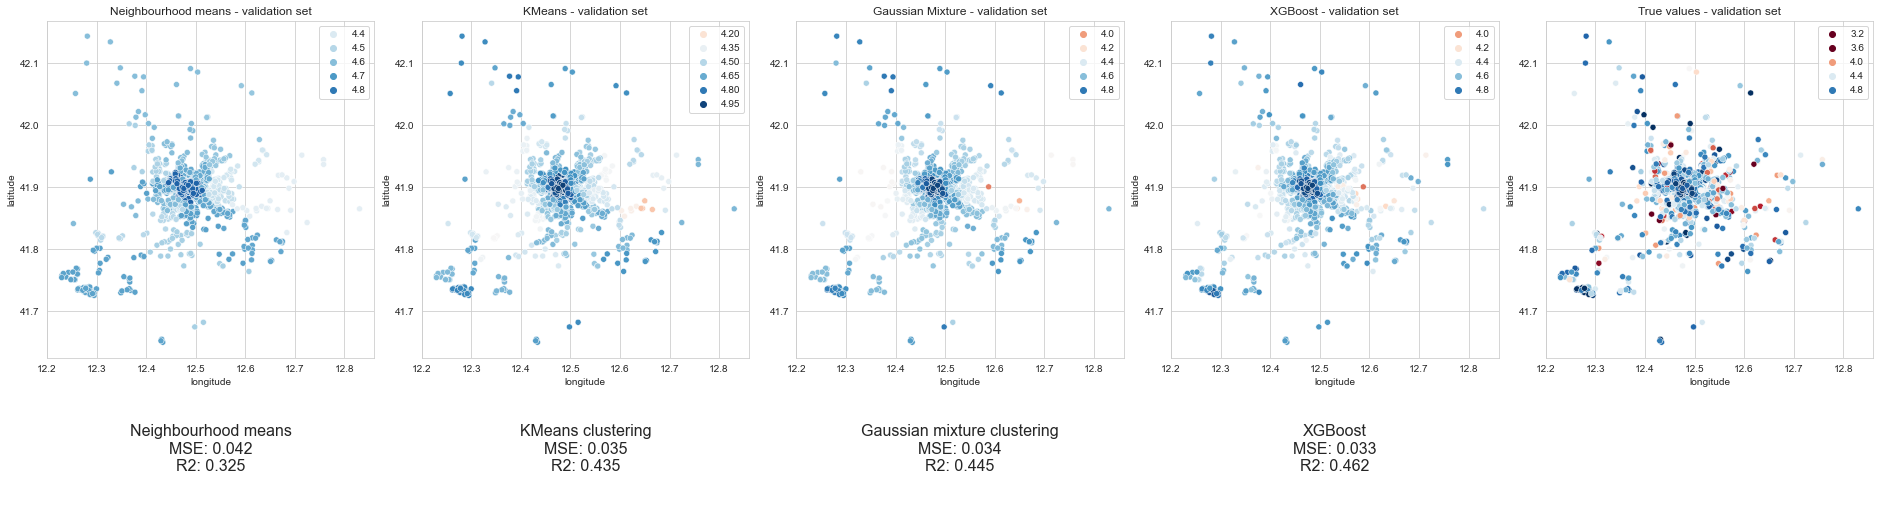

In [80]:
#fig, ax = plt.subplots(1,5, figsize=(26,6))
fig = plt.figure(constrained_layout=True, figsize=(26, 7))
heights = [3, 1]
gs = fig.add_gridspec(ncols=5, nrows= 2, height_ratios=heights)

ax = fig.add_subplot(gs[0, 0])
sns.scatterplot(data=X_val, x='longitude', y='latitude', hue=y_pred_n_mean, hue_norm=(3.6,5), palette='RdBu', ax=ax)
ax.legend(title='')
ax.set_title('Neighbourhood means - validation set')

ax = fig.add_subplot(gs[0, 1])
sns.scatterplot(data=X_val, x='longitude', y='latitude', hue=y_pred_km, hue_norm=(3.6,5), palette='RdBu', ax=ax)
ax.legend(title='')
ax.set_title('KMeans - validation set')

ax = fig.add_subplot(gs[0, 2])
sns.scatterplot(data=X_val, x='longitude', y='latitude', hue=y_pred_gm, hue_norm=(3.6,5), palette='RdBu', ax=ax)
ax.legend(title='')
ax.set_title('Gaussian Mixture - validation set')

ax = fig.add_subplot(gs[0, 3])
sns.scatterplot(data=X_val, x='longitude', y='latitude', hue=y_pred_xgb, hue_norm=(3.6,5), palette='RdBu', ax=ax)
ax.legend(title='')
ax.set_title('XGBoost - validation set')

ax = fig.add_subplot(gs[0, 4])
sns.scatterplot(data=X_val, x='longitude', y='latitude', hue=y_val['review_scores_location'], hue_norm=(3.6,5), palette='RdBu', ax=ax)
ax.legend(title='')
ax.set_title('True values - validation set')

# metrics
anno_opts = dict(xy=(0.5, 0.5), xycoords='axes fraction', va='center', ha='center', size=16)

ax = fig.add_subplot(gs[1, 0])
ax.axis('off')
s = 'Neighbourhood means\nMSE: {:.3f}\nR2: {:.3f}'.format(mse_n, r2_n)
ax.annotate(s, **anno_opts)

ax = fig.add_subplot(gs[1, 1])
ax.axis('off')
s = 'KMeans clustering\nMSE: {:.3f}\nR2: {:.3f}'.format(mse_km, r2_km)
ax.annotate(s, **anno_opts)
            
ax = fig.add_subplot(gs[1, 2])
ax.axis('off')
s = 'Gaussian mixture clustering\nMSE: {:.3f}\nR2: {:.3f}'.format(mse_gm, r2_gm)
ax.annotate(s, **anno_opts)

ax = fig.add_subplot(gs[1, 3])
ax.axis('off')
s = 'XGBoost\nMSE: {:.3f}\nR2: {:.3f}'.format(mse_xg, r2_xg)
ax.annotate(s, **anno_opts)

plt.show()

Out of these models, the XGBoost regression implementation performs the best, with the lowest mean squared error and the highest R2 coefficient. Additionally, the visualization shows that the XGBoost approach is the only model that demonstrates the capability of differentiating between relatively closely situated properties that should still receive quite different location scores (e.g. lower left corner). Nevertheless, the R2 score of around 0.5 is still far from optimal and thus there is a lot of variance not explained by the model.

The visuals also show that the ML models struggle noticeably with the worse locations, those with a review score of 4 and under.

**Ideas on how to improve the model(s):**
 - New features, would have to be obtained elsewhere as the airbnb data does not include these:
    - Distance to nearest metro station / bus stop
    - Distance to nearest grocery store
    - Distance to nearest restaurant and/or other services

### **Categorized location score**

Now, let us attempt classifying samples to quartiles - e.g. it might be enough information to know that a location is in the top 25% of all locations.

Reminder on the categorization done earlier:
 - 0 refers to the first (worst) quartile, 0% to 25%
 - 1 refers to the second quartile
 - 2 refers to the third quartile
 - 3 refers to the fourth quartile, representing the top 25% of all locations.

Unlike in the previous section, this is now a classification task which allows for different ML models to be tested. 
The clustering and regression approaches had trouble accurately predicting the scores of bad locations as they represent a clear minority of all samples. Theoretically, the classification approach could fare better since the categorization leads to all classes being equally represented.

In [81]:
# define visualization function
def plot_classification_performance(model, X_data, y_true, y_predicted, only_metrics=False):
    fig, ax = plt.subplots(1, 3, figsize=(26,8))

    if not only_metrics:
        cm = confusion_matrix(y_true, y_predicted, labels=model.classes_)
        disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
        disp.plot(cmap='Blues', ax=ax[0])
        ax[0].grid(False)

        sns.scatterplot(ax=ax[1], data=X_data, x='longitude', y='latitude', hue=y_true, palette='RdBu', hue_norm=(np.min(y_true), np.max(y_true)))
        ax[1].set_title('true values')
        sns.scatterplot(ax=ax[2], data=X_data, x='longitude', y='latitude', hue=y_predicted, palette='RdBu', hue_norm=(np.min(y_true), np.max(y_true)))
        ax[2].set_title('predicted values')

        plt.tight_layout()
        plt.show()

    # print classification metrics
    print(classification_report(y_true, y_predicted))
    print('Cohen kappa score: {:.3f}'.format(cohen_kappa_score(y_true, y_predicted)))

#### Random Forest Classifier

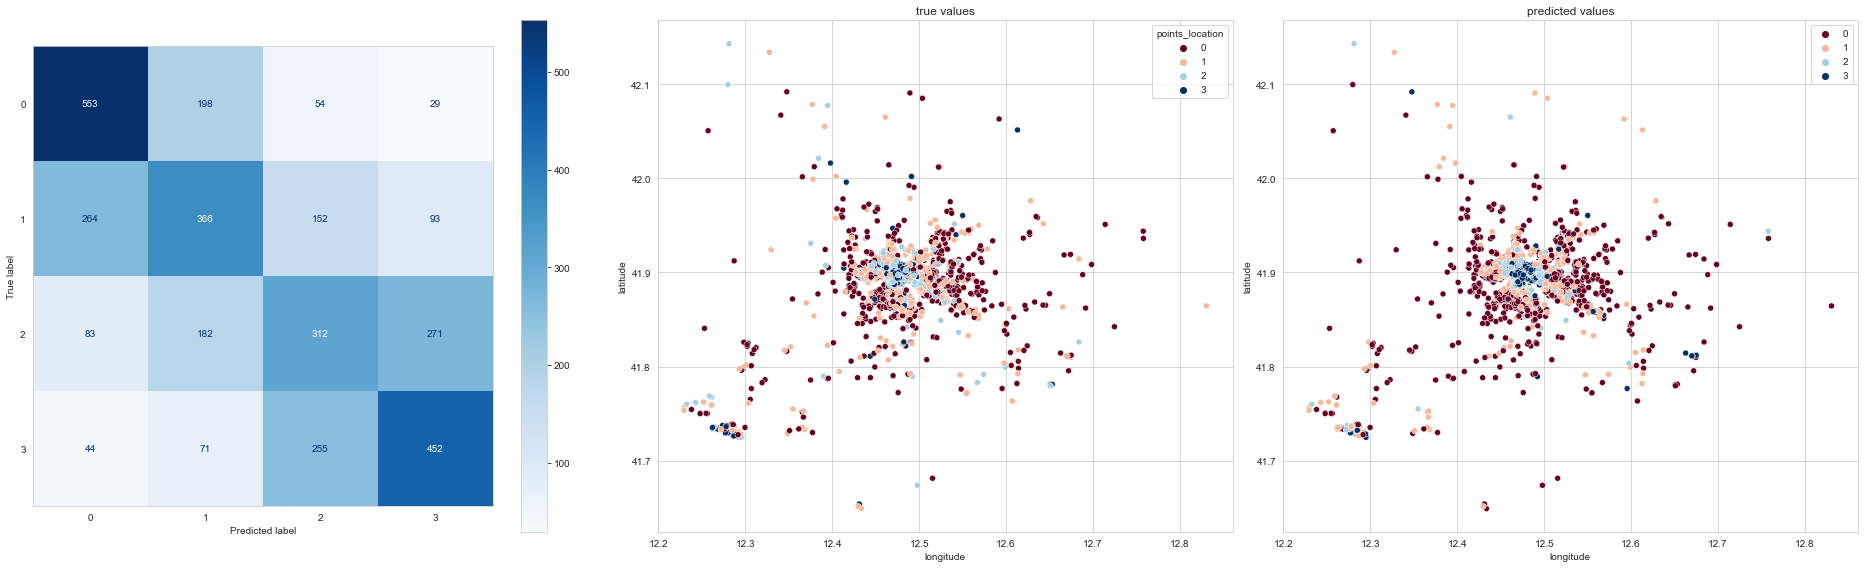

              precision    recall  f1-score   support

           0       0.59      0.66      0.62       834
           1       0.45      0.42      0.43       875
           2       0.40      0.37      0.38       848
           3       0.53      0.55      0.54       822

    accuracy                           0.50      3379
   macro avg       0.49      0.50      0.50      3379
weighted avg       0.49      0.50      0.49      3379

Cohen kappa score: 0.331


In [82]:
model = RandomForestClassifier(n_estimators=200, criterion='gini')
model.fit(X_train[['longitude', 'latitude']], y_train['points_location'])

y_pred = model.predict(X_val[['longitude', 'latitude']])

plot_classification_performance(model, X_val, y_val['points_location'], y_pred)

#### XGBoost

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}


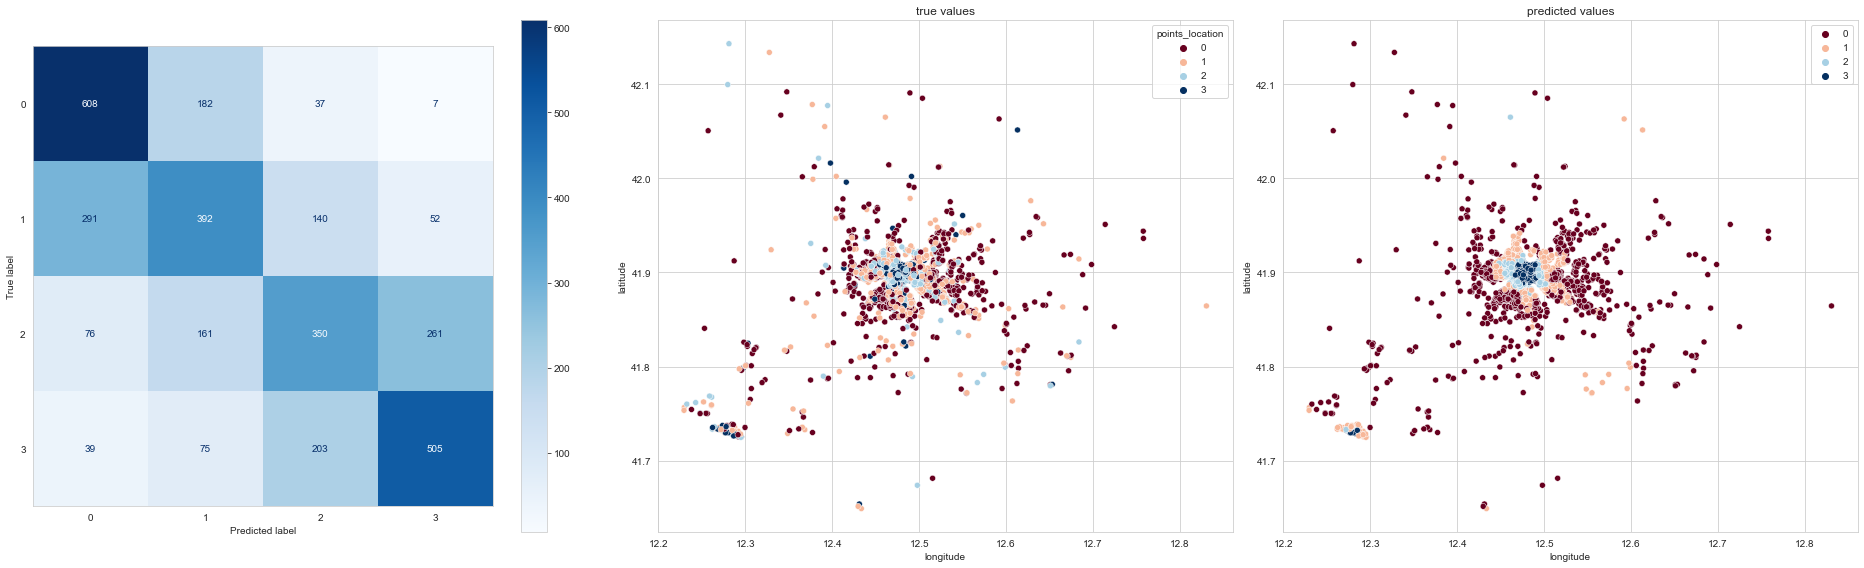

              precision    recall  f1-score   support

           0       0.60      0.73      0.66       834
           1       0.48      0.45      0.47       875
           2       0.48      0.41      0.44       848
           3       0.61      0.61      0.61       822

    accuracy                           0.55      3379
   macro avg       0.54      0.55      0.55      3379
weighted avg       0.54      0.55      0.54      3379

Cohen kappa score: 0.399


In [83]:
#implement grid search
params = {'max_depth': [5,], #preliminary testing showed 5 consistently outperforming
          'learning_rate': [0.01, 0.05, 0.1],
          'n_estimators': [100, 500, 1000],
          }

xgbc = xgb.XGBClassifier(objective='multi:softmax')
clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring='neg_log_loss', verbose=1, refit=True, n_jobs=-1)
clf.fit(X_train[['longitude', 'latitude']], y_train['points_location'])
y_pred = clf.predict(X_val[['longitude', 'latitude']])

print('Best params:', clf.best_params_)

plot_classification_performance(model, X_val, y_val['points_location'], y_pred)

# save model for later
model_xgb_quart = clf.best_estimator_

The prediction performance of any of these models is not very good although they still clearly beat a randomized draw. This means that the models are able to find patterns from the data, but struggle with accurately determining the correct class. 

The confusion matrices of both the above models display two darker square areas, in the top left and in the bottom right. This is due to the models beings somewhat accurate in the sense that they mostly predict the class correctly or as the neighbouring class. **Because of this result, it could be worthwhile to simplify the model and turn this into a binary classification task instead.**

This is detailed below:

### **Categorized Location Score - Binary Classification**

Now, the location scores are classified as follows:
 - Bottom 50% location scores are labeled as **0** (was previously 0 and 1)
 - Top 50% location scores are labeled as **1** (was previously 2 and 3)

This are likely to improve the classification performance. As a tradeoff, the information obtained from the model is less useful as it now differentiates only between "good" and "bad" locations whereas previously there were four different levels present.

#### Random Forest Classifier

*Using the same hyperparameters as in the multiclass version for simplicity*

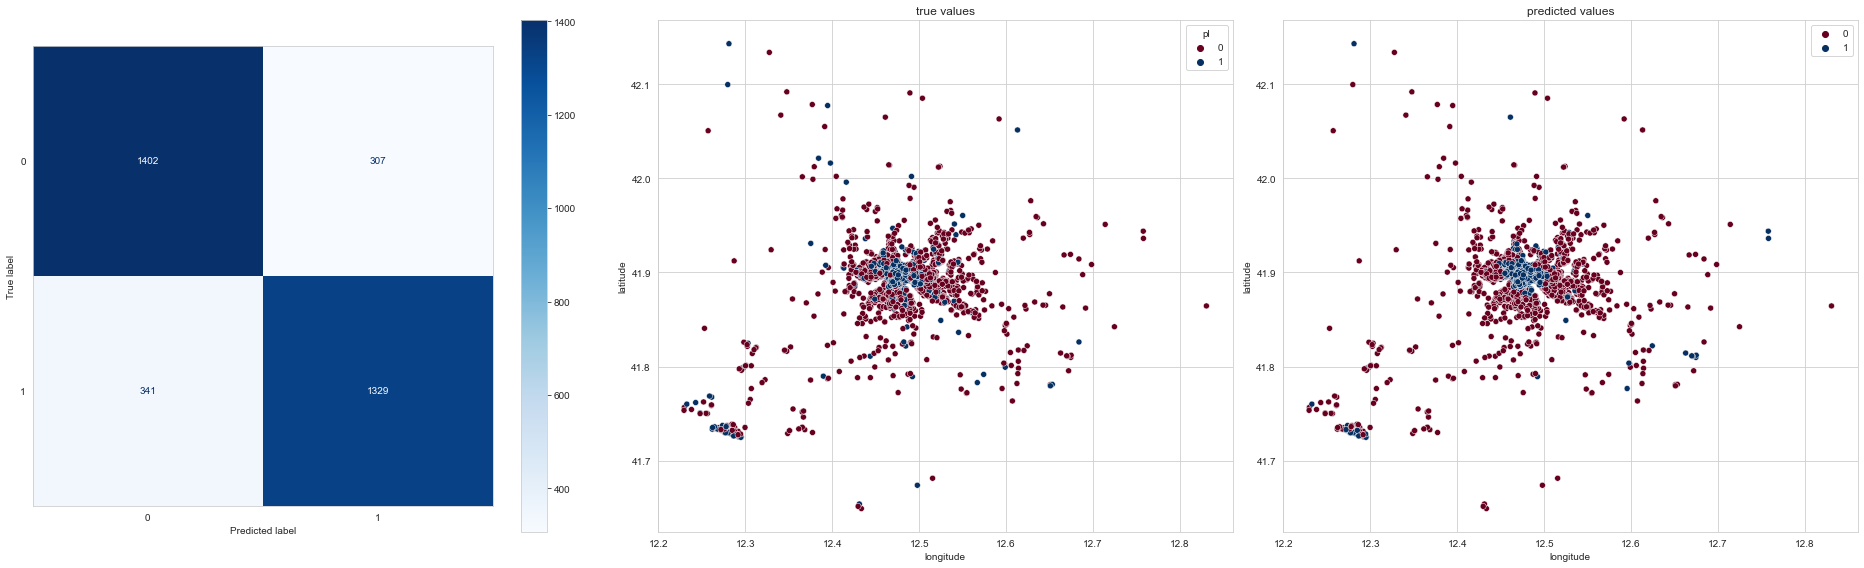

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1709
           1       0.81      0.80      0.80      1670

    accuracy                           0.81      3379
   macro avg       0.81      0.81      0.81      3379
weighted avg       0.81      0.81      0.81      3379

Cohen kappa score: 0.616


In [84]:
y_train['pl'] = np.where(y_train['points_location'] <= 1, 0, 1)
y_val['pl'] = np.where(y_val['points_location'] <= 1, 0, 1)

model = RandomForestClassifier(n_estimators=200, criterion='gini')
model.fit(X_train[['longitude', 'latitude']], y_train['pl'])

y_pred = model.predict(X_val[['longitude', 'latitude']])

plot_classification_performance(model, X_val, y_val['pl'], y_pred)

y_train.drop(['pl'], axis=1, inplace=True)
y_val.drop(['pl'], axis=1, inplace=True)

#### XGBoost

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}


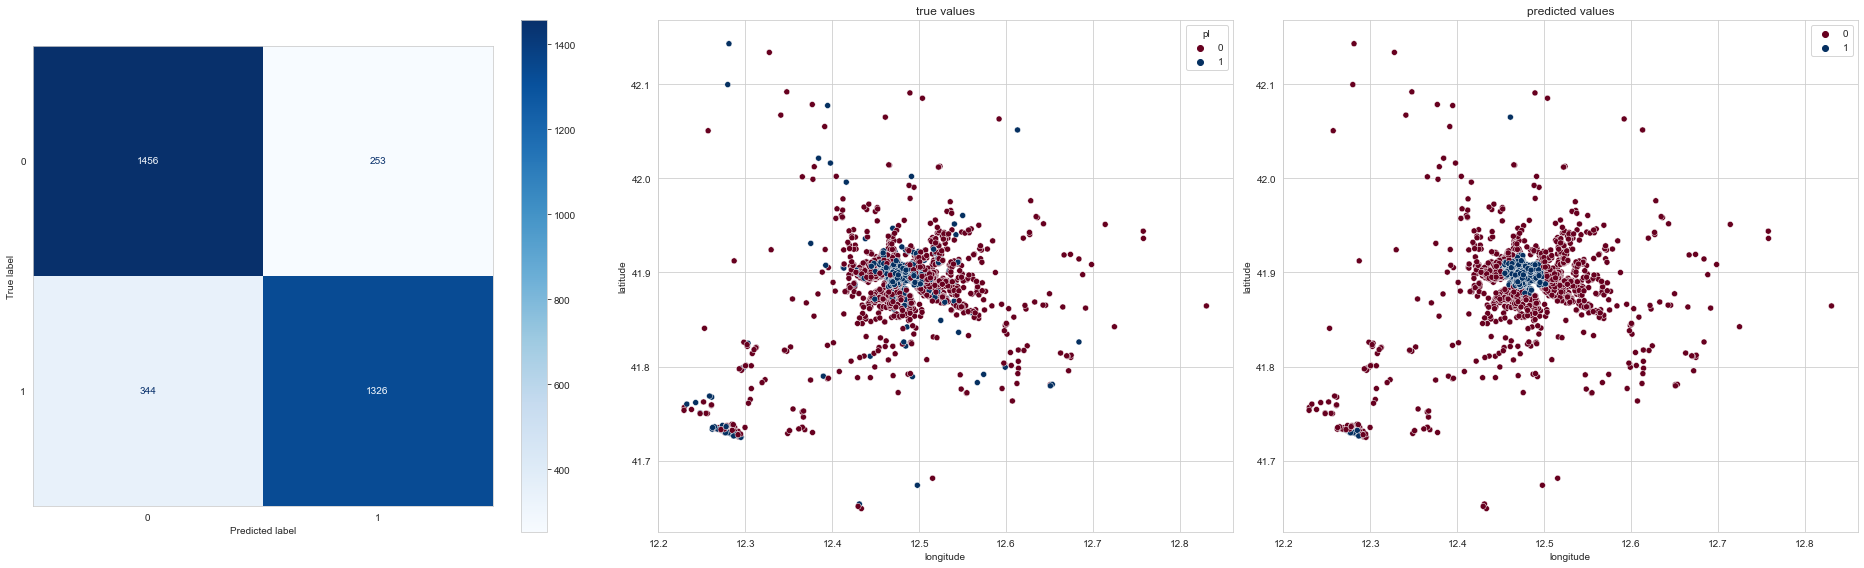

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1709
           1       0.84      0.79      0.82      1670

    accuracy                           0.82      3379
   macro avg       0.82      0.82      0.82      3379
weighted avg       0.82      0.82      0.82      3379

Cohen kappa score: 0.646


In [85]:
y_train['pl'] = np.where(y_train['points_location'] <= 1, 0, 1)
y_val['pl'] = np.where(y_val['points_location'] <= 1, 0, 1)

#implement grid search
params = {'max_depth': [5,],
          'learning_rate': [0.01, 0.05, 0.1],
          'n_estimators': [100, 500, 1000],
          }

xgbc = xgb.XGBClassifier(objective='reg:logistic')
clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring='neg_log_loss', verbose=1, refit=True, n_jobs=-1)
clf.fit(X_train[['longitude', 'latitude']], y_train['pl'])
y_pred = clf.predict(X_val[['longitude', 'latitude']])

print('Best params:', clf.best_params_)

plot_classification_performance(clf, X_val, y_val['pl'], y_pred)

y_train.drop(['pl'], axis=1, inplace=True)
y_val.drop(['pl'], axis=1, inplace=True)

# save best estimator
model_xgb_bin = clf.best_estimator_

## **Conclusions**

In [86]:
corr = df[['review_scores_location', 'points_location', 'review_scores_cleanliness', 'review_scores_rating', 'popularity', 'price', 'accommodates']].corr()
corr.style.background_gradient(cmap='Blues', axis=None).format(precision=2)

,review_scores_location,points_location,review_scores_cleanliness,review_scores_rating,popularity,price,accommodates
review_scores_location,1.00,0.84,0.26,0.36,0.16,0.15,0.10
points_location,0.84,1.00,0.18,0.27,0.14,0.18,0.10
review_scores_cleanliness,0.26,0.18,1.00,0.77,0.10,0.02,-0.02
review_scores_rating,0.36,0.27,0.77,1.00,0.17,0.01,0.02
popularity,0.16,0.14,0.10,0.17,1.00,-0.08,-0.01
price,0.15,0.18,0.02,0.01,-0.08,1.00,0.33
accommodates,0.10,0.10,-0.02,0.02,-0.01,0.33,1.00


Airbnb customers seem to score a listing's location quite independently of the other review variables. Location score is one of the variables that form the immediately visible overall rating of a Airbnb listing, and therefore it is important to be able to assess this before potentially purchasing a property for this use.

From the correlation matrix we can see that in addition to affecting the overall rating, the location score also somewhat affects the popularity of a listing. A good location is also somewhat correlated with a higher price, which logically makes sense and interestingly, a good location for a property does not mean that the size of the property has to shrink. 

It is likely that most Airbnb hosts live quite close to their listings and/or have other connections to the geographical locations which should give the hosts knowledge on what locations are considered "good". However, this knowledge should still be supplemented with knowledge on what locations the Airbnb customer base considers good - these might not always overlap!

**Predictive models**

In this notebook, models for predicting Airbnb location scores have been presented and explored. The location score has been addressed in three different ways: as the original **review score**, categorized into **quartiles** and categorized into **halves**. Next, the best performing models in all three will be assessed on unseen data - meaning the separate test set.

Incidentally, the best performing model for each out of the tested ones turned out to be XGBoost. It should be noted, however, that the performance between different models was very similar and it could be possible to achieve better performance with more work. *For more accurate prediction, it would also be beneficial to include data on nearby services, public transport and points of interest.*

In [87]:
print('On test set:')
X_trainval = pd.concat(objs=[X_train, X_val], axis=0)
y_trainval = pd.concat(objs=[y_train, y_val], axis=0)

print('Location review score (XGBoost):')
model_xgb.fit(X_trainval[['longitude', 'latitude']], y_trainval['review_scores_location'])
y_pred_test_lrs = model_xgb.predict(X_test[['longitude', 'latitude']])
mse_test_lrs = mean_squared_error(y_test['review_scores_location'], y_pred_test_lrs)
r2_test_lrs = r2_score(y_test['review_scores_location'], y_pred_test_lrs)
print(' - MSE: {:.3f}'.format(mse_test_lrs))
print(' - R2: {:.2f}'.format(r2_test_lrs))


print('\nCategorized multiclass quartiles (XGBoost):')
model_xgb_quart.fit(X_trainval[['longitude', 'latitude']], y_trainval['points_location'])
y_pred_test_quart = model_xgb_quart.predict(X_test[['longitude', 'latitude']])
print(classification_report(y_test[['points_location']], y_pred_test_quart))

print('\nCategorized binary (XGBoost):')
y_trainval['pl'] = np.where(y_trainval['points_location'] <= 1, 0, 1)
y_test['pl'] = np.where(y_test['points_location'] <= 1, 0, 1)
model_xgb_bin.fit(X_trainval[['longitude', 'latitude']], y_trainval['pl'])
y_pred_test_bin = model_xgb_bin.predict(X_test[['longitude', 'latitude']])
print(classification_report(y_test[['pl']], y_pred_test_bin))

On test set:
Location review score (XGBoost):
 - MSE: 0.033
 - R2: 0.46

Categorized multiclass quartiles (XGBoost):
              precision    recall  f1-score   support

           0       0.60      0.69      0.64       831
           1       0.45      0.45      0.45       863
           2       0.48      0.43      0.45       857
           3       0.61      0.58      0.59       829

    accuracy                           0.54      3380
   macro avg       0.53      0.54      0.53      3380
weighted avg       0.53      0.54      0.53      3380


Categorized binary (XGBoost):
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1694
           1       0.85      0.80      0.83      1686

    accuracy                           0.83      3380
   macro avg       0.83      0.83      0.83      3380
weighted avg       0.83      0.83      0.83      3380



The performance of every model on unseen data is similar to the performance on validation data. Therefore, the models do not overfit.

**As the last step, the models are trained with data from different cities of Italy to see if they perform similarly independent of the city. The models are also tuned on per-city basis as the cities are different enough to likely benefit from differing hyperparameters.**

In [88]:
def test_models(city):
    print('{} - performance on test data'.format(city))
    
    pd.options.mode.chained_assignment = None
    
    # load and preprocess
    data = pd.read_csv('Airbnb Italy/' + city + '/listings.csv')
    data = data[[
    'last_scraped',
    'neighbourhood_cleansed', 'latitude', 'longitude',
    'room_type', 'accommodates', 'bathrooms_text','bedrooms', 'amenities',
    'price',
    'number_of_reviews', 'first_review', 'last_review',
    'availability_30', 'availability_60', 'availability_90', 'availability_365',
    'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'reviews_per_month'
    ]]
    data.dropna(inplace=True)
    data['last_scraped'] = data['last_scraped'].astype('datetime64[ns]')
    data['first_review'] = data['first_review'].astype('datetime64[ns]')
    data['last_review'] = data['last_review'].astype('datetime64[ns]')

    # drop assumed to be fake
    data = data.query('number_of_reviews >= 4')
    
    # categorize
    q25 = data['review_scores_location'].quantile(0.25)
    q50 = data['review_scores_location'].quantile(0.50)
    q75 = data['review_scores_location'].quantile(0.75)
    criteria = [data['review_scores_location'] <= q25, (data['review_scores_location'] > q25) & (data['review_scores_location'] <= q50), 
                (data['review_scores_location'] > q50) & (data['review_scores_location'] <= q75), data['review_scores_location'] > q75]
    values = [0, 1, 2, 3]
    data['points_location'] = np.select(criteria, values, 0)
    
    # split to train, test, val - 60%, 20%, 20%
    y = data[['review_scores_location', 'points_location']]
    X = data[['longitude', 'latitude']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
    
    # use both training and test sets for final model training
    X_train = pd.concat(objs=[X_train, X_val], axis=0)
    y_train = pd.concat(objs=[y_train, y_val], axis=0)
    
    # common params for all models
    params = {
        'max_depth': [5,],
        'n_estimators': [100, 1000],
        'learning_rate': [0.01, 0.05, 0.1],
    }

    # location review score regr
    model_lrs = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, refit=True, verbose=0)
    model_lrs.fit(X_train, y_train['review_scores_location'])
    y_pred_lrs = model_lrs.predict(X_test)
    mse_lrs = mean_squared_error(y_test['review_scores_location'], y_pred_lrs)
    r2_lrs = r2_score(y_test['review_scores_location'], y_pred_lrs)
    
    # quartiles classification
    model_quartile = GridSearchCV(xgb.XGBClassifier(objective='multi:softmax'), param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, refit=True, verbose=0)
    model_quartile.fit(X_train, y_train['points_location'])
    y_pred_quartile = model_quartile.predict(X_test)
    acc_quartile = accuracy_score(y_test['points_location'], y_pred_quartile)
    prec_quartile = precision_score(y_test['points_location'], y_pred_quartile, average='weighted')
    rec_quartile = recall_score(y_test['points_location'], y_pred_quartile, average='weighted')
    cm_quartile = confusion_matrix(y_test['points_location'], y_pred_quartile, labels=model_quartile.classes_)
    
    # binary classification
    y_train['pl'] = np.where(y_train['points_location'] <= 1, 0, 1)
    y_test['pl'] = np.where(y_test['points_location'] <= 1, 0, 1)
    model_binary = GridSearchCV(xgb.XGBClassifier(objective='reg:logistic'), param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, refit=True, verbose=0)
    model_binary.fit(X_train, y_train['pl'])
    y_pred_binary = model_binary.predict(X_test)
    acc_binary = accuracy_score(y_test['pl'], y_pred_binary)
    prec_binary = precision_score(y_test['pl'], y_pred_binary)
    rec_binary = recall_score(y_test['pl'], y_pred_binary)
    cm_binary = confusion_matrix(y_test['pl'], y_pred_binary, labels=model_binary.classes_)
    
    
    # plot results
    # ------------------------------------------------------------------------------------------------------------------------------------------------------------------
    fig = plt.figure(constrained_layout=True, figsize=(26, 5))
    heights = [4, 1]
    gs = fig.add_gridspec(ncols=5, nrows= 2, height_ratios=heights)
    
    # lrs map
    ax = fig.add_subplot(gs[0, 0])
    sns.scatterplot(ax=ax, data=X_test, x='longitude', y='latitude', hue=y_pred_lrs, palette='RdBu')
    ax.set_title('Location review score (predicted)')
    
    # quartile cm and map
    ax = fig.add_subplot(gs[0, 1])
    disp = ConfusionMatrixDisplay(cm_quartile, display_labels=model_quartile.classes_)
    disp.plot(cmap='Blues', ax=ax)
    ax.grid(False)
    ax.set_title('Categorized location score - multi class (predicted)')
    ax = fig.add_subplot(gs[0, 2])
    sns.scatterplot(ax=ax, data=X_test, x='longitude', y='latitude', hue=y_pred_quartile, palette='RdBu')
    
    # binary cm and map
    ax = fig.add_subplot(gs[0, 3])
    disp = ConfusionMatrixDisplay(cm_binary, display_labels=model_binary.classes_)
    disp.plot(cmap='Blues', ax=ax)
    ax.grid(False)
    ax.set_title('Categorized location score - binary (predicted)')
    ax = fig.add_subplot(gs[0, 4])
    sns.scatterplot(ax=ax, data=X_test, x='longitude', y='latitude', hue=y_pred_binary, palette='RdBu', hue_norm=(0,1))
    
    # lrs metrics
    ax = fig.add_subplot(gs[1, 0])
    ax.axis('off')
    s = 'MSE: {:.3f}\nR2: {:.3f}'.format(mse_lrs, r2_lrs)
    anno_opts = dict(xy=(0.5, 0.5), xycoords='axes fraction', va='center', ha='center', size=14)
    ax.annotate(s, **anno_opts)
    
    # quartile metrics
    ax = fig.add_subplot(gs[1, 1])
    ax.axis('off')
    s = 'Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}'.format(acc_quartile, prec_quartile, rec_quartile)
    anno_opts = dict(xy=(0.8, 0.5), xycoords='axes fraction', va='center', ha='center', size=14)
    ax.annotate(s, **anno_opts)
    
    # binary metrics
    ax = fig.add_subplot(gs[1, 3])
    ax.axis('off')
    s = 'Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}'.format(acc_binary, prec_binary, rec_binary)
    ax.annotate(s, **anno_opts)
    
    plt.plot([0.22, 0.22], [0, 1], color='black', lw=3, transform=plt.gcf().transFigure, clip_on=False)
    plt.plot([0.62, 0.62], [0, 1], color='black', lw=3, transform=plt.gcf().transFigure, clip_on=False)
    
    plt.show()

Bergamo - performance on test data


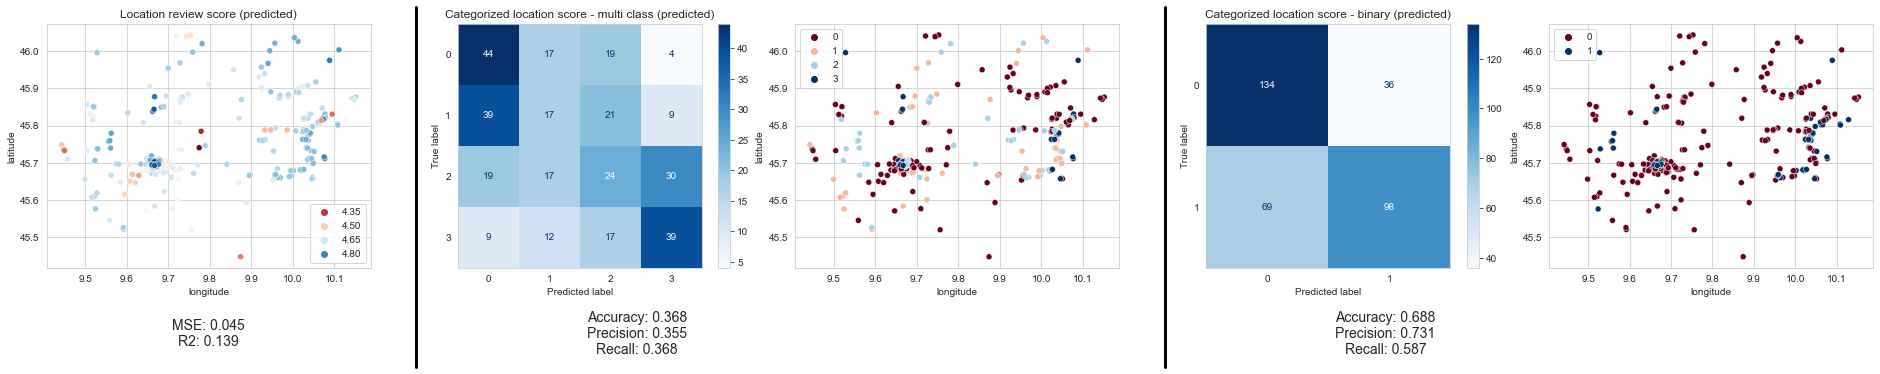

Bologna - performance on test data


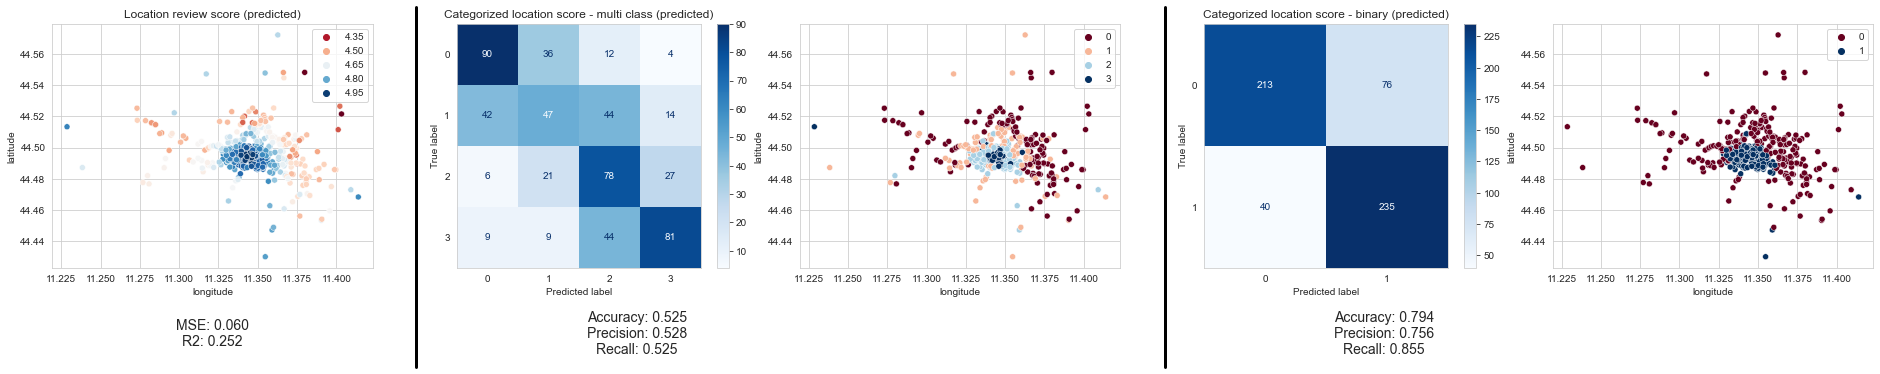

Firenze - performance on test data


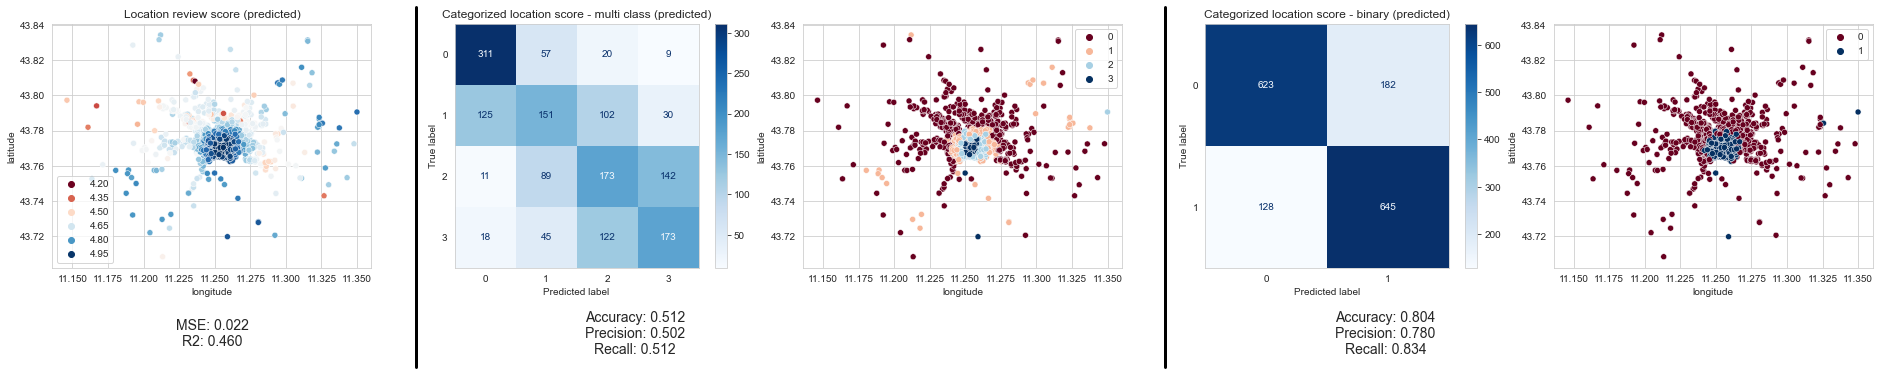

Milano - performance on test data


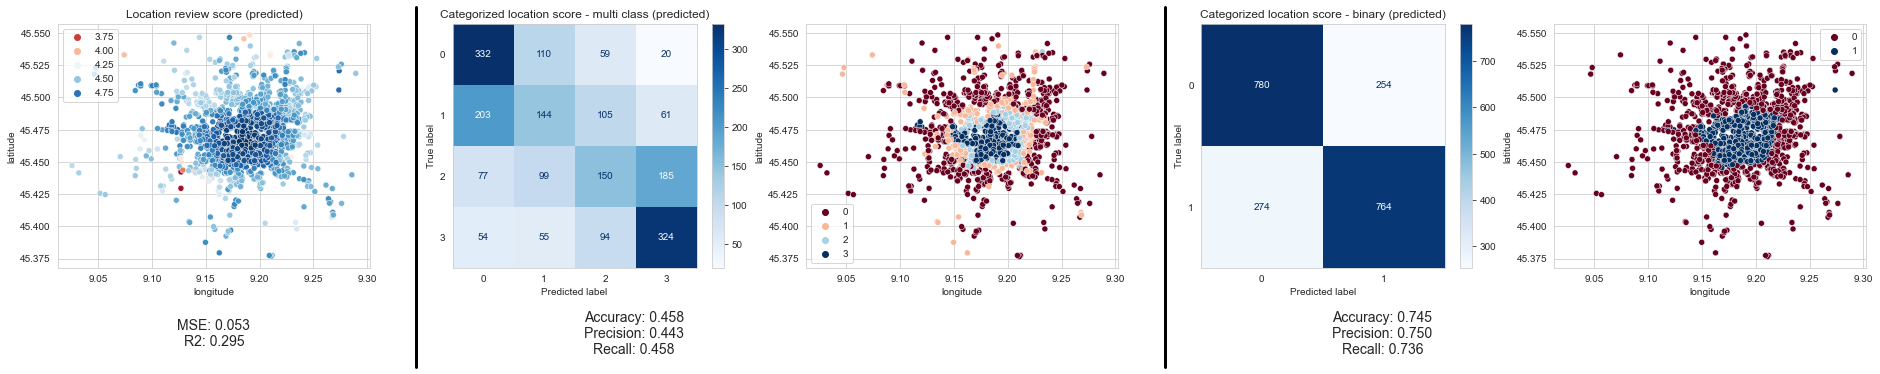

Napoli - performance on test data


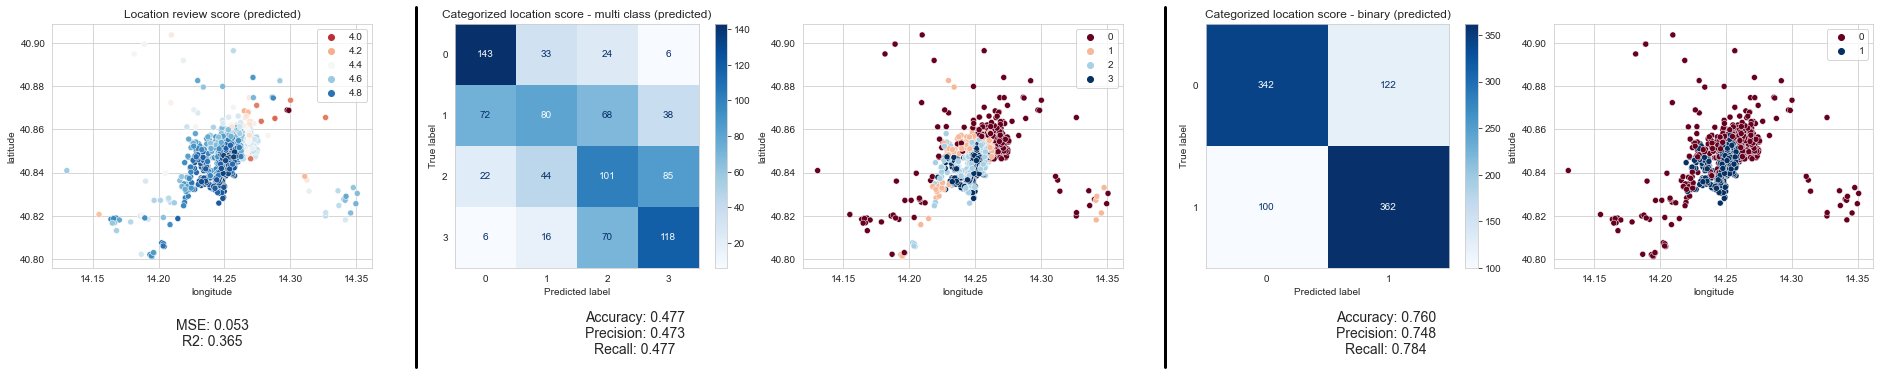

Puglia - performance on test data


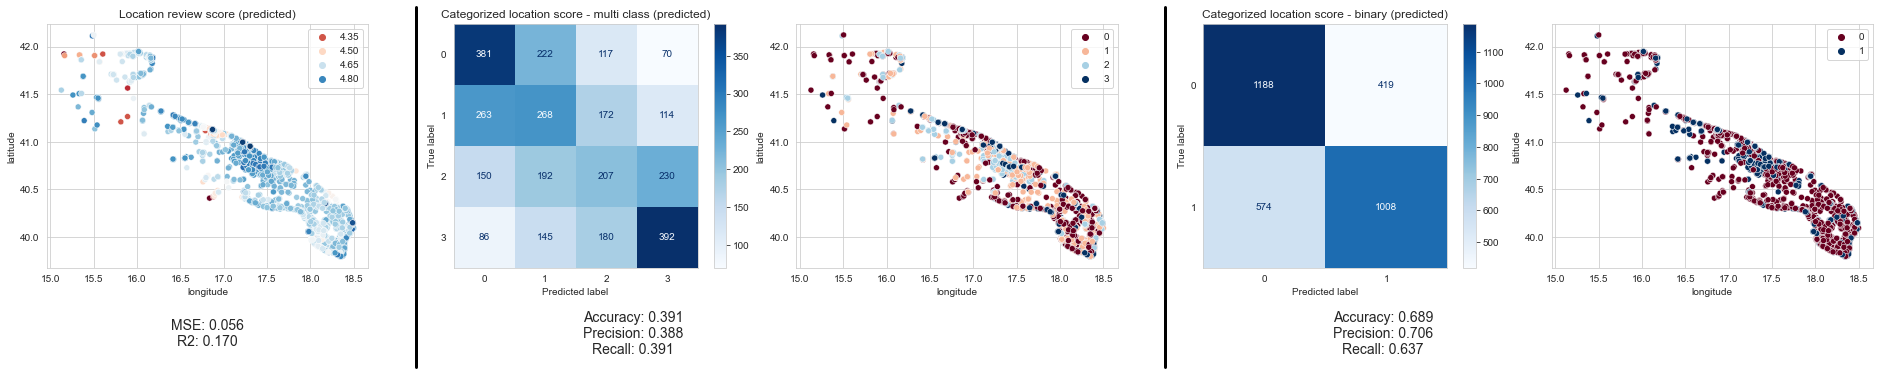

Roma - performance on test data


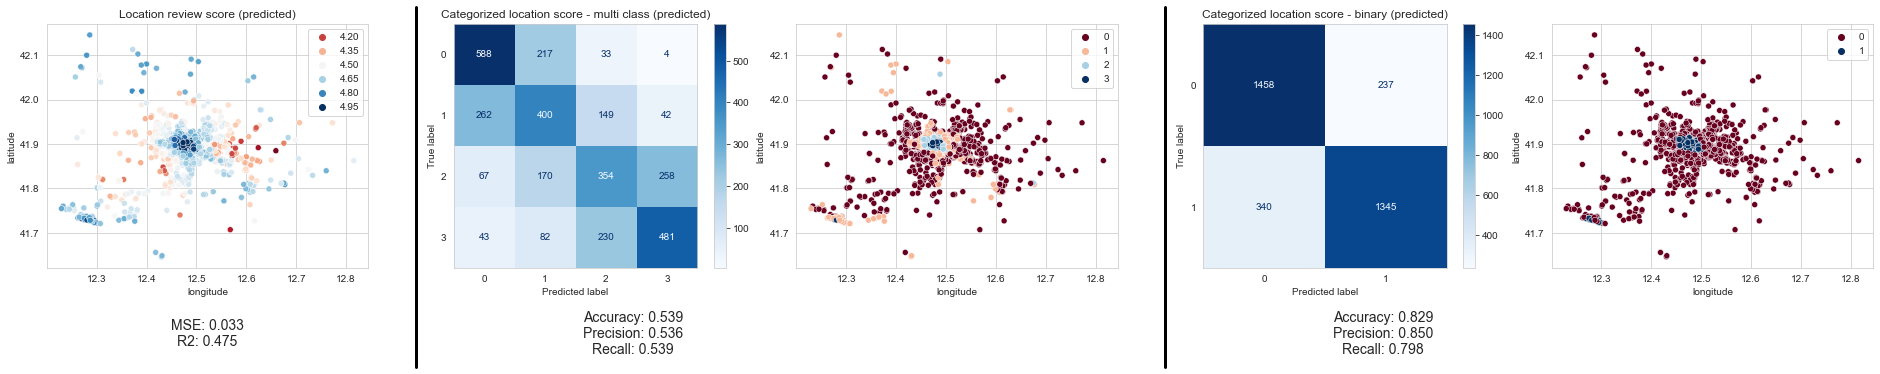

Sicilia - performance on test data


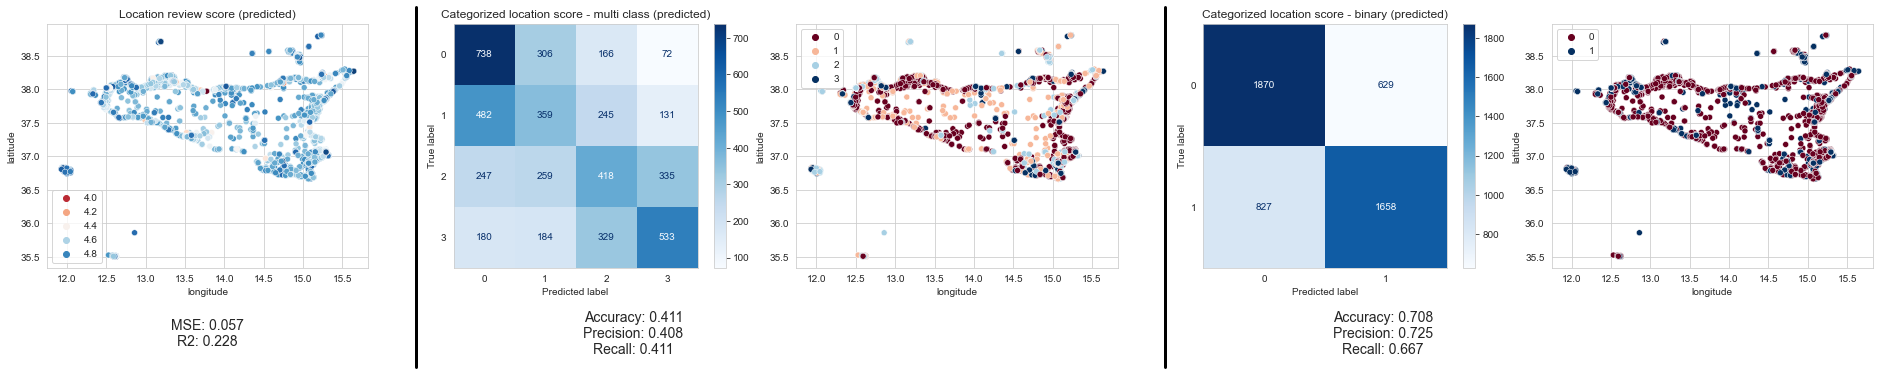

Trentino - performance on test data


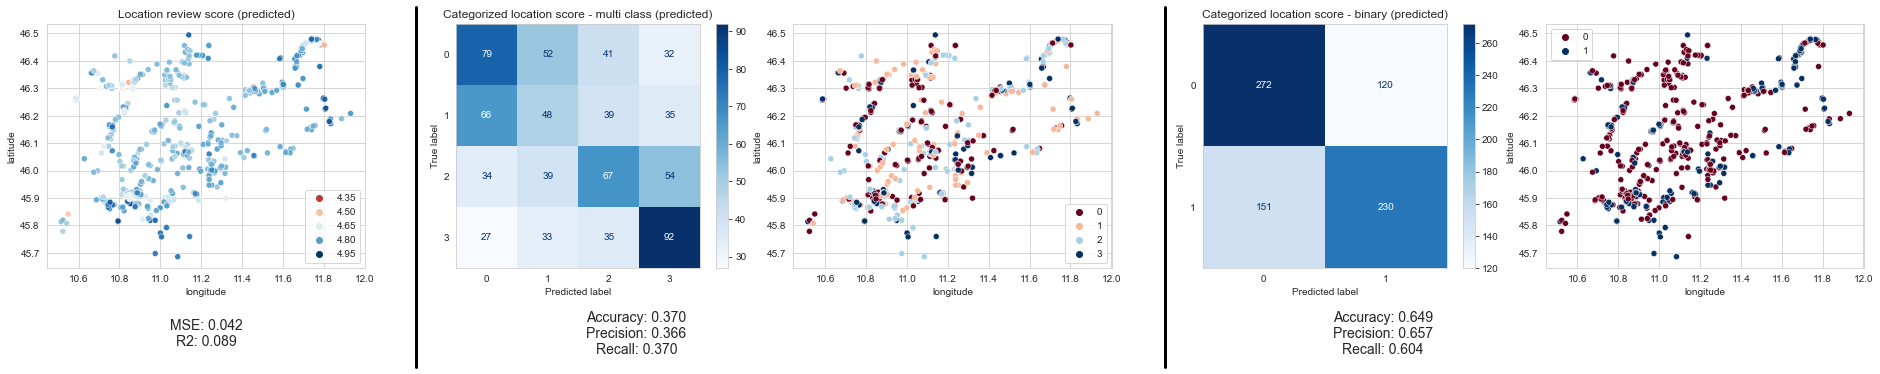

Venezia - performance on test data


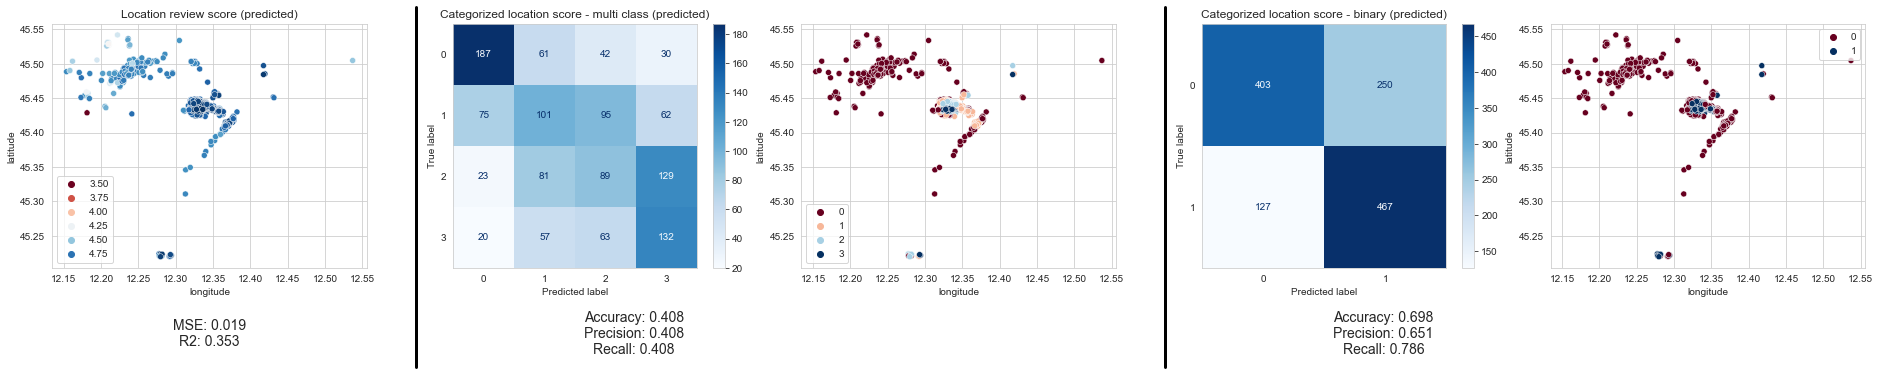

In [89]:
cities = ['Bergamo', 'Bologna', 'Firenze', 'Milano', 'Napoli', 'Puglia', 'Roma', 'Sicilia', 'Trentino', 'Venezia']
for c in cities:
    if RUN_SUMMARY:
        test_models(c)
    else: break

The proposed methods seem to perform quite similarly in all the cities. The exception are cities/areas with a small number of listings and no distinct centre area (e.g. Trentino, Bergamo). In these locations, the regression model (location review score) performs very poorly. The classification models also seem so suffer in these locations, but the difference is smaller. 

**The best performance overall is achieved with larger data size and clearly defined location "clusters". This suggests, that these methods are best suited for large cities and/or other built up areas, with a clear central district.**